# Big Data - Librería `PySpark`
---

Trabajaremos con la librería PySpark que presenta las interfaces de Spark en Python. A lo largo del trabajo recurriremos a librerías propias de python como `numpy`, `pandas` y algunas de visiualización como `seaborn` para obtener una mejor comprensión de los datos. Sin embargo, las etapas de la recopilación, preprocesado y modelado se realizarán usando la lógica de `pyspark`.

# Librerias
---

In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, VectorSlicer
from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.regression import LinearRegression, LinearRegressionModel, RandomForestRegressor, GBTRegressor, GBTRegressionModel

from pyspark.ml.evaluation import Evaluator
from math import sqrt
from pyspark.sql.functions import avg, log
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt

# Inicialización
---
De esta forma, tenemos acceso a distintas funciones gracias a la variable de contexto `spark`.

In [1]:
spark = SparkSession.builder.master("local[*]").appName("trabajo_APBD") \
    .getOrCreate()
spark

# Lectura de los ficheros
---
Este caso de estudio hace referencia a una competición publicada en Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques, en la que se debe predecir el salario de diferentes hogares.

La descripción es la siguiente:

> Pídale a un comprador de vivienda que describa la casa de sus sueños, y probablemente no comenzarán con la altura del techo del sótano. Pero el conjunto de datos de esta competición se observa que el patio de recreo influye mucho más en las negociaciones de precios que el número de habitaciones o una cancilla blanca. Con 80 variables explicativas que describen (casi) todos los aspectos de las casas residenciales en Ames, Iowa, se debe predecir el precio final de cada casa.

Disponemos de dos conjuntos de datos:

* **train.csv**: conjunto de entrenamiento.
* **test.csv**: conjunto de testeo (`submission`)

In [2]:
train_df = spark.read.csv(path='../datos-trabajo-final-APBD-2019/train.csv', header = True, inferSchema = True)
test_df = spark.read.csv(path='../datos-trabajo-final-APBD-2019/test.csv', header = True, inferSchema = True)

## Características de los conjuntos de datos

In [3]:
print("El número de registros del data set train es: {} \nEl número de registros del test: {}".format(train_df.count(),
                                                                                                      test_df.count()))

El número de registros del data set train es: 1460 
El número de registros del test: 1459


In [4]:
col = train_df.columns
col_test = test_df.columns
print("El número de total de variables/columnas de nuestro conjunto de datos train es:", len(col))
print("El número de variables del conjunto test es:", len(col_test))

El número de total de variables/columnas de nuestro conjunto de datos train es: 81
El número de variables del conjunto test es: 80


Vemos que la variable objetivo **SalePrice** no está presente en nuestro dataset test, luego deberemos incluirla cuando queramos efectuar la unificación de los dos conjuntos de datos:

In [5]:
train_df.columns

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

Analizamos qué tipo tiene cada variable usando **printSchema()**:

In [6]:
train_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

Podemos obtener una descripción de cada una de las 81 variables usando la función **describe()**, sin embargo, la salida es inmensa. Nuestra variable a predecir es aquella que lleva por nombre **SalePrice**, obtenemos un resumen de la misma:

In [7]:
train_df.select("SalePrice").describe().show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|             34900|
|    max|            755000|
+-------+------------------+



# Análisis Exploratorio de los datos
---

## Unificación de los conjunto de datos

Hemos visto que el número de columnas no coincide en ambos data sets pues en el conjunto test no aparece la variable objetivo. Por lo tanto en primer lugar debemos añadir a nuestro 'test_df' la variable 'SalePrice' de tipo numérico, lo haremos usando la función `withColumn()`:

In [8]:
test_df = test_df.withColumn('SalePrice', F.lit(None).cast(IntegerType()))
test_df.select('SalePrice').show()

+---------+
|SalePrice|
+---------+
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
|     null|
+---------+
only showing top 20 rows



Esta variable de valores 'null' es la variable de la cual queremos conocer sus predicciones.

Para hacer factible la unión de los datasets, deben tener el mismo orden las variables y ser del mismo tipo:

In [9]:
print("Train:", train_df.columns, "\n")
print("Test:", test_df.columns)

Train: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', '

Vemos que ambos conjuntos de datos tienen el mismo número de variables y su orden coincide. Nos falta ver si las variables son del mismo tipo en ambos datasets:

In [10]:
types_train = [f.dataType for f in train_df.schema.fields]
types_test = [f.dataType for f in test_df.schema.fields]

In [11]:
dif = [i for i in range(len(types_test)) if types_test[i] != types_train[i]]
dif

[34, 36, 37, 38, 47, 48, 61, 62]

Hemos alcanzado las posiciones de las variables cuyo tipo no coincide en ambos conjuntos de datos. Debemos asignarles el mismo tipo para hacer posible la unificación:

In [12]:
for i in dif:
    print(train_df.schema.fields[i])
    print(test_df.schema.fields[i])

StructField(BsmtFinSF1,IntegerType,true)
StructField(BsmtFinSF1,StringType,true)
StructField(BsmtFinSF2,IntegerType,true)
StructField(BsmtFinSF2,StringType,true)
StructField(BsmtUnfSF,IntegerType,true)
StructField(BsmtUnfSF,StringType,true)
StructField(TotalBsmtSF,IntegerType,true)
StructField(TotalBsmtSF,StringType,true)
StructField(BsmtFullBath,IntegerType,true)
StructField(BsmtFullBath,StringType,true)
StructField(BsmtHalfBath,IntegerType,true)
StructField(BsmtHalfBath,StringType,true)
StructField(GarageCars,IntegerType,true)
StructField(GarageCars,StringType,true)
StructField(GarageArea,IntegerType,true)
StructField(GarageArea,StringType,true)


Tras un análisis de cada una de las variables de la salida obtenida llegamos a la conclusión de que dichas variables han de ser numéricas:

In [13]:
test_df = test_df \
    .withColumn('BsmtFinSF1', test_df.BsmtFinSF1.cast(IntegerType())) \
    .withColumn('BsmtFinSF2', test_df.BsmtFinSF2.cast(IntegerType())) \
    .withColumn('BsmtUnfSF', test_df.BsmtUnfSF.cast(IntegerType())) \
    .withColumn('TotalBsmtSF', test_df.TotalBsmtSF.cast(IntegerType())) \
    .withColumn('BsmtFullBath', test_df.BsmtFullBath.cast(IntegerType())) \
    .withColumn('BsmtHalfBath', test_df.BsmtHalfBath.cast(IntegerType())) \
    .withColumn('GarageCars', test_df.GarageCars.cast(IntegerType())) \
    .withColumn('GarageArea', test_df.GarageArea.cast(IntegerType()))

Realizamos la misma comprobación de antes:

In [14]:
types_train = [f.dataType for f in train_df.schema.fields]
types_test_mod = [f.dataType for f in test_df.schema.fields]

[i for i in range(len(types_test)) if types_test_mod[i] != types_train[i]]

[]

Realizamos a continuación la unión del conjunto de aprendizaje y del conjunto test:

In [15]:
full_df = train_df.union(test_df)
print("El número de filas del dataset final es: {} \nEl número de columnas es: {}".format(full_df.count(), 
                                                                                         len(full_df.columns)))

El número de filas del dataset final es: 2919 
El número de columnas es: 81


Representamos las primeras observaciones de las 5 primeras columnas y de las 5 últimas. Además, realizamos una breve descripción de dichas variables:

In [16]:
full_df.select(full_df.columns[:5]).show()

+---+----------+--------+-----------+-------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|
+---+----------+--------+-----------+-------+
|  1|        60|      RL|         65|   8450|
|  2|        20|      RL|         80|   9600|
|  3|        60|      RL|         68|  11250|
|  4|        70|      RL|         60|   9550|
|  5|        60|      RL|         84|  14260|
|  6|        50|      RL|         85|  14115|
|  7|        20|      RL|         75|  10084|
|  8|        60|      RL|         NA|  10382|
|  9|        50|      RM|         51|   6120|
| 10|       190|      RL|         50|   7420|
| 11|        20|      RL|         70|  11200|
| 12|        60|      RL|         85|  11924|
| 13|        20|      RL|         NA|  12968|
| 14|        20|      RL|         91|  10652|
| 15|        20|      RL|         NA|  10920|
| 16|        45|      RM|         51|   6120|
| 17|        20|      RL|         NA|  11241|
| 18|        90|      RL|         72|  10791|
| 19|        20|      RL|         

In [17]:
full_df.describe(full_df.columns[:5]).show()

+-------+-----------------+------------------+--------+------------------+-----------------+
|summary|               Id|        MSSubClass|MSZoning|       LotFrontage|          LotArea|
+-------+-----------------+------------------+--------+------------------+-----------------+
|  count|             2919|              2919|    2919|              2919|             2919|
|   mean|           1460.0|  57.1377183967112|    null| 69.30579531442663|10168.11408016444|
| stddev|842.7870430897713|42.517627829150314|    null|23.344904706927394|7886.996359105535|
|    min|                1|                20| C (all)|               100|             1300|
|    max|             2919|               190|      RM|                NA|           215245|
+-------+-----------------+------------------+--------+------------------+-----------------+



**Comentario**

Observamos en la variable *LotFrontage* cierta particularidad: no se han detectado los registros faltantes. Dichos registros vienen dados por el carácter 'NA', luego necesitamos convertirlos a valores missing para posteriormente imputarlos correctamente.

La presencia del carácter 'NA' merece la pena comentarlo: en algunas variables categóricas detectamos la presencia de una categoría 'NA' indicando la ausencia de dicho establecimiento en la casa (es el caso de las variables: 'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PoolQC' o 'Fence'). Sin embargo, en la lectura de los ficheros detectamos la presencia de más registros 'NA', como hemos dicho, entendemos dichos valores como registros faltantes para posteriormente imputarlos. En el caso de las variables categóricas se verá más adelante cómo se tratara este asunto.

In [18]:
full_df.select(full_df.columns[:75:-1]).show()

+---------+-------------+--------+------+------+
|SalePrice|SaleCondition|SaleType|YrSold|MoSold|
+---------+-------------+--------+------+------+
|   208500|       Normal|      WD|  2008|     2|
|   181500|       Normal|      WD|  2007|     5|
|   223500|       Normal|      WD|  2008|     9|
|   140000|      Abnorml|      WD|  2006|     2|
|   250000|       Normal|      WD|  2008|    12|
|   143000|       Normal|      WD|  2009|    10|
|   307000|       Normal|      WD|  2007|     8|
|   200000|       Normal|      WD|  2009|    11|
|   129900|      Abnorml|      WD|  2008|     4|
|   118000|       Normal|      WD|  2008|     1|
|   129500|       Normal|      WD|  2008|     2|
|   345000|      Partial|     New|  2006|     7|
|   144000|       Normal|      WD|  2008|     9|
|   279500|      Partial|     New|  2007|     8|
|   157000|       Normal|      WD|  2008|     5|
|   132000|       Normal|      WD|  2007|     7|
|   149000|       Normal|      WD|  2010|     3|
|    90000|       No

In [19]:
full_df.describe(full_df.columns[:75:-1]).show()

+-------+------------------+-------------+--------+------------------+-----------------+
|summary|         SalePrice|SaleCondition|SaleType|            YrSold|           MoSold|
+-------+------------------+-------------+--------+------------------+-----------------+
|  count|              1460|         2919|    2919|              2919|             2919|
|   mean|180921.19589041095|         null|    null|2007.7927372387803|6.213086673518328|
| stddev| 79442.50288288663|         null|    null|1.3149644889049965|2.714761774157895|
|    min|             34900|      Abnorml|     COD|              2006|                1|
|    max|            755000|      Partial|      WD|              2010|               12|
+-------+------------------+-------------+--------+------------------+-----------------+



**Nota:** vemos que la función **count()** devuelve el número de elementos válidos dentro de la función **describe()**. Vemos que si se han detectado los registros missing de la variable respuesta, 'SalePrice', de ahí que la salida de la función *count()* de dicha variable sea inferior al nº de registros totales.

Observamos el tipo de cada variable en el set de datos resultante:

In [20]:
full_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

## Preprocesamiento de los datos: limpieza y cambio de tipo de atributos

Observamos algunas irregularidades en el dataset creado:

* Algunos valores perdidos 'NaN' aparecen como strings 'NA' luego cuando queramos localizarlos no será posible. Por tanto, debemos realizar dicho cambio para posteriormente imputarlos.
* Existen una serie de variables que precisan un cambio de tipo.

* **Analizamos el número de valores 'NA' en cada variable del set de datos**
Posteriormente veremos que dichos valores 'NA' representan la gran mayoría de registros faltantes en nuestro dataframe.

In [21]:
full_df_count_NA = full_df.agg(*[F.count(F.when(F.col(c) == "NA", c)).alias(c) for c in full_df.columns])

from functools import reduce
full_df_count_NA_col = reduce(
    lambda a, b: a.union(b),
    (
        full_df_count_NA.select(F.lit(c).alias("Column_Name"), F.col(c).alias("NA_Count")) 
        for c in full_df_count_NA.columns
    )
)
full_df_count_NA_col.show()

+------------+--------+
| Column_Name|NA_Count|
+------------+--------+
|          Id|       0|
|  MSSubClass|       0|
|    MSZoning|       4|
| LotFrontage|     486|
|     LotArea|       0|
|      Street|       0|
|       Alley|    2721|
|    LotShape|       0|
| LandContour|       0|
|   Utilities|       2|
|   LotConfig|       0|
|   LandSlope|       0|
|Neighborhood|       0|
|  Condition1|       0|
|  Condition2|       0|
|    BldgType|       0|
|  HouseStyle|       0|
| OverallQual|       0|
| OverallCond|       0|
|   YearBuilt|       0|
+------------+--------+
only showing top 20 rows



Observamos las variables que presentan el carácter 'NA' como valor:

In [22]:
full_df_count_NA_col.filter(F.col('NA_Count') > 0).show()

+------------+--------+
| Column_Name|NA_Count|
+------------+--------+
|    MSZoning|       4|
| LotFrontage|     486|
|       Alley|    2721|
|   Utilities|       2|
| Exterior1st|       1|
| Exterior2nd|       1|
|  MasVnrType|      24|
|  MasVnrArea|      23|
|    BsmtQual|      81|
|    BsmtCond|      82|
|BsmtExposure|      82|
|BsmtFinType1|      79|
|BsmtFinType2|      80|
|  Electrical|       1|
| KitchenQual|       1|
|  Functional|       2|
| FireplaceQu|    1420|
|  GarageType|     157|
| GarageYrBlt|     159|
|GarageFinish|     159|
+------------+--------+
only showing top 20 rows



Como hemos comentado la presencia de dichos valores en determinadas variables significa ausencia; por ejemplo, no hay garage, no hay piscina, no hay sótano, etc. Sin embargo, la presencia de dicho valor en variables numéricas (que son la gran mayoria) debemos entenderlo como un registro faltante. Podríamos realizar dos análisis; por un lado las variables que tiene sentido que presenten dicho caracter y por otro las que debemos imputarlas como valor missing, sin embargo, reeemplazaremos todos dichos carácters por valores missing y posteriormente veremos, si hace falta, cómo tratar aquellas variables con dicha peculiaridad.

Así, reemplazamos los valores 'NA' por 'None' para defnir dichos registros como valores faltantes y posteriormente imputarlos.

In [23]:
full_df = full_df.replace("NA", None)

* **Efectuamos el cambio del tipo de variables**

Tras un profundo análisis de cada una de las variables de nuestro conjunto de datos nos encontramos ante la existencia de algunas a las que debemos cambiarle el tipo.

In [25]:
full_df.select('LotFrontage', 'MasVnrArea', 'GarageYrBlt').printSchema()

root
 |-- LotFrontage: string (nullable = true)
 |-- MasVnrArea: string (nullable = true)
 |-- GarageYrBlt: string (nullable = true)



In [26]:
full_df = full_df \
    .withColumn('LotFrontage', full_df.LotFrontage.cast(IntegerType())) \
    .withColumn('MasVnrArea', full_df.MasVnrArea.cast(IntegerType())) \
    .withColumn('GarageYrBlt', full_df.GarageYrBlt.cast(IntegerType()))

In [27]:
full_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

### Procesamiento de valores missing

Para el cálculo de los valores missing que pueden presentar las distintas variables seguiremos los siguientes pasos:

* Asociaremos a cada registro de cada columna, **F.col(c)**, el valor true or false en función de si el registro es un valor perdido o no gracias a la función **isNull()**.
* Posteriormente, convertiremos los false en 0 y los true en 1 y sumaremos los valores de cada columna, obteniéndose así el número de registros nulos en cada columna.


* **Procedimiento para la obtención del número de registros faltantes en cada variable**

In [28]:
def count_nulls(c):
    return F.sum(F.col(c).isNull().cast(IntegerType())).alias(c)

# Definimos la operación para cada columna del DF
exprs = [count_nulls(c) for c in full_df.columns]

# Aplicamos todas las operaciones
full_df.agg(*exprs).show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

Indicamos otra forma de llevar a cabo dicho conteo: guardamos en un dataframe el objeto previamente creado y, posteriormente, creamos un dataframe con dos columnas donde la primera hace referencia al nombre de los factores y la segunda al número de registros faltantes.

Además, creamos la **función que nos permita calcular el número de registros nulos para posterior cálculos**.

In [29]:
full_df_agg = full_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns])

def count_nulls_df(df):
    return reduce(
        lambda a, b: a.union(b),
        (
            df.select(F.lit(c).alias("Column_Name"), F.col(c).alias("NULL_Count"))
            for c in df.columns
        )
    )

full_df_agg_col = count_nulls_df(full_df_agg)

full_df_agg_col.sort(F.desc("NULL_Count")).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|      PoolQC|      2909|
| MiscFeature|      2814|
|       Alley|      2721|
|       Fence|      2348|
|   SalePrice|      1459|
| FireplaceQu|      1420|
| LotFrontage|       486|
|  GarageQual|       159|
|GarageFinish|       159|
|  GarageCond|       159|
| GarageYrBlt|       159|
|  GarageType|       157|
|BsmtExposure|        82|
|    BsmtCond|        82|
|    BsmtQual|        81|
|BsmtFinType2|        80|
|BsmtFinType1|        79|
|  MasVnrType|        24|
|  MasVnrArea|        23|
|    MSZoning|         4|
+------------+----------+
only showing top 20 rows



In [30]:
full_df_agg_col.filter(F.col('NULL_Count') > 0).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|    MSZoning|         4|
| LotFrontage|       486|
|       Alley|      2721|
|   Utilities|         2|
| Exterior1st|         1|
| Exterior2nd|         1|
|  MasVnrType|        24|
|  MasVnrArea|        23|
|    BsmtQual|        81|
|    BsmtCond|        82|
|BsmtExposure|        82|
|BsmtFinType1|        79|
|  BsmtFinSF1|         1|
|BsmtFinType2|        80|
|  BsmtFinSF2|         1|
|   BsmtUnfSF|         1|
| TotalBsmtSF|         1|
|  Electrical|         1|
|BsmtFullBath|         2|
|BsmtHalfBath|         2|
+------------+----------+
only showing top 20 rows



* **Comparación con los registros 'NA'**

Observamos que además de los registros 'NA', que hemos imputado por valores missing, había más registros faltantes.

In [31]:
full_df_count_NA_col.agg(F.sum("NA_count")).show()
full_df_agg_col.agg(F.sum("NULL_count")).show()

+-------------+
|sum(NA_count)|
+-------------+
|        13955|
+-------------+

+---------------+
|sum(NULL_count)|
+---------------+
|          15424|
+---------------+



A priori puede resultar que había un gran número de valores missing en nuestras variables significativas sin embargo no es así. En la salida de los valores **null** se encuentran los 1459 de la variable objetivo que, por supuesto, no estaban en el análisis de los valores 'NA'. Contando esta son sólo 10 registros faltantes (10+1459+13955 = 15424) los que se encontraban inicialmente en nuestro conjunto de datos.

Vemos el número de registros nulos de nuestra variable a predecir:

In [32]:
full_df_agg.select('SalePrice').show() # coincide con el número de registros del conjunto test

+---------+
|SalePrice|
+---------+
|     1459|
+---------+



El conteo sobre la variable objetivo hace referencia al número de registros del conjunto test. Recordamos que dicha variable no existía en dicho conjunto de datos, la creamos con valores **null** puesto que es la variable que queremos predecir.

* **Creamos a continuación una función que nos devuelva el porcentaje de registros missing por variable:**

In [33]:
def pct_nulls(df):
    return [100*(df.filter(F.col(c).isNull()).count() / df.count()) for c in df.columns]

In [34]:
df_pct_nulls = pd.DataFrame({'Factors': full_df.columns, 'Porcentaje nulos': pct_nulls(full_df)})
df_pct_nulls = df_pct_nulls.sort_values(by='Porcentaje nulos', ascending=False)

Convertimos el dataframe en formato pandas en formato **spark** para seguir con nuestro análisis.

In [36]:
df_pct_nulls_spark = spark.createDataFrame(df_pct_nulls)

In [37]:
df_pct_nulls_spark.sort(F.desc('Porcentaje nulos')).show()

+------------+------------------+
|     Factors|  Porcentaje nulos|
+------------+------------------+
|      PoolQC| 99.65741692360398|
| MiscFeature| 96.40287769784173|
|       Alley| 93.21685508735868|
|       Fence|  80.4385063377869|
|   SalePrice|  49.9828708461802|
| FireplaceQu|48.646796848235695|
| LotFrontage|16.649537512846866|
|GarageFinish|5.4470709146968135|
| GarageYrBlt|5.4470709146968135|
|  GarageCond|5.4470709146968135|
|  GarageQual|5.4470709146968135|
|  GarageType| 5.378554299417608|
|    BsmtCond|2.8091812264474134|
|BsmtExposure|2.8091812264474134|
|    BsmtQual| 2.774922918807811|
|BsmtFinType2|2.7406646111682083|
|BsmtFinType1|2.7064063035286057|
|  MasVnrType|0.8221993833504625|
|  MasVnrArea|0.7879410757108599|
|    MSZoning|0.1370332305584104|
+------------+------------------+
only showing top 20 rows



Ahora bien, eliminaremos aquellas columnas (explicativas) que presenten como mínimo el $45\%$ de registros perdidos. Observamos que dichas variables: 'Alley', 'PoolQC', 'Fence', 'MiscFeature' y 'FireplaceQu' no se tratan de aspectos de vital importancia ante la decisión de la compra de una casa, posiblemente, es por dicha razón por la que dichas columnas presentan un número tan elevado de registros missing. Observamos que todas ellas significan la presencia o no de diversos elementos no prioritarios en una casa: piscina, callejón, valla, chimenea.

Los valores missing de dichas variables son los valores de carácter 'NA' que han sido reemplazos por 'None' y que, como hemos dicho, significan la ausencia de un elemento extra en una casa. Por ejemplo la variable que determina la presencia de piscina tiene prácticamente todos sus registros 'NA' y por consiguiente para la elaboración de un modelo no es significativo. Por la existencia tan alta de una categoría que convierte dichas variables en prácticamente constante y puesto que no son aspectos tan importantes desde el punto de vista técnico, decidimos eliminarlas de nuestro dataset.

In [38]:
df_pct_nulls_spark.filter((df_pct_nulls_spark['Porcentaje nulos'] > 45) &
                         (df_pct_nulls_spark['Factors'] != "SalePrice")).sort(F.desc('Porcentaje nulos')).show()

+-----------+------------------+
|    Factors|  Porcentaje nulos|
+-----------+------------------+
|     PoolQC| 99.65741692360398|
|MiscFeature| 96.40287769784173|
|      Alley| 93.21685508735868|
|      Fence|  80.4385063377869|
|FireplaceQu|48.646796848235695|
+-----------+------------------+



La variable 'SalePrice' require una explicación aparte; se trata de la variable objetivo y sus registros nulos se deben a que el conjunto test presenta dicha columna vacía pues es la variable a predecir.

Accedemos ahora a las variables que cumplen dicha condicion:

In [39]:
to_drop = df_pct_nulls_spark.filter((df_pct_nulls_spark['Porcentaje nulos'] > 45) & (F.col('Factors') != "SalePrice"))\
    .select('Factors')

to_drop.show()

+-----------+
|    Factors|
+-----------+
|     PoolQC|
|MiscFeature|
|      Alley|
|      Fence|
|FireplaceQu|
+-----------+



In [40]:
full_df = full_df.drop('Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu')

Observamos ahora el número de registros nulos por variable que necesitamos imputar:

In [41]:
new_full_df = full_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns])

new_full_df_drop = count_nulls_df(new_full_df)
new_full_df_drop.show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|          Id|         0|
|  MSSubClass|         0|
|    MSZoning|         4|
| LotFrontage|       486|
|     LotArea|         0|
|      Street|         0|
|    LotShape|         0|
| LandContour|         0|
|   Utilities|         2|
|   LotConfig|         0|
|   LandSlope|         0|
|Neighborhood|         0|
|  Condition1|         0|
|  Condition2|         0|
|    BldgType|         0|
|  HouseStyle|         0|
| OverallQual|         0|
| OverallCond|         0|
|   YearBuilt|         0|
|YearRemodAdd|         0|
+------------+----------+
only showing top 20 rows



Observamos ahora qué variables necesitan llevar a cabo una tarea de preprocesamiento de valores missing (aquellas cuyo número de registros faltantes sea superior a 1).

In [42]:
new_full_df_drop.filter(F.col('NULL_Count') >= 1).sort(F.asc('NULL_Count')).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|  GarageCars|         1|
|  BsmtFinSF1|         1|
| Exterior2nd|         1|
| Exterior1st|         1|
|  BsmtFinSF2|         1|
| TotalBsmtSF|         1|
|   BsmtUnfSF|         1|
|  Electrical|         1|
|  GarageArea|         1|
| KitchenQual|         1|
|    SaleType|         1|
|  Functional|         2|
|   Utilities|         2|
|BsmtFullBath|         2|
|BsmtHalfBath|         2|
|    MSZoning|         4|
|  MasVnrArea|        23|
|  MasVnrType|        24|
|BsmtFinType1|        79|
|BsmtFinType2|        80|
+------------+----------+
only showing top 20 rows



**LotFrontage - 486 registros missing**

Dicha variable significa: pies lineales de calle conectados a propiedad. De manera que para conocer el área de cada casa, como todas las casas que se rodean entre sí tendrán aproximadamente la misma área, podemos reemplazar el área a calcular por el área de cada barrio (variable **Neighborhood**).

In [43]:
miss_LotFr = full_df.filter(full_df.LotFrontage.isNull())

no_miss_LotFr = full_df.filter(full_df.LotFrontage.isNotNull())

Calculamos pues la media de la variable 'LotFrontage' por barrio:

In [44]:
df_mean_LotFr_neigh = no_miss_LotFr.groupBy('Neighborhood').agg(F.avg(no_miss_LotFr.LotFrontage).alias('mean_LotFrontage'))
df_mean_LotFr_neigh.show()

+------------+------------------+
|Neighborhood|  mean_LotFrontage|
+------------+------------------+
|     Veenker|              72.0|
|     BrkSide| 55.78947368421053|
|     NPkVill|28.142857142857142|
|     NridgHt|  84.1840490797546|
|     NoRidge| 91.62962962962963|
|      NWAmes| 81.51764705882353|
|     OldTown|61.777292576419214|
|     Gilbert|  74.2072072072072|
|     Somerst| 64.54938271604938|
|     Crawfor| 69.95180722891567|
|       NAmes| 75.21066666666667|
|      IDOTRR|62.241379310344826|
|     Edwards| 66.91011235955057|
|      Sawyer| 74.55102040816327|
|     StoneBr| 62.17391304347826|
|     CollgCr| 71.33636363636364|
|       SWISU| 59.06818181818182|
|     MeadowV|25.606060606060606|
|      Timber| 81.15789473684211|
|     Blmngtn|              46.9|
+------------+------------------+
only showing top 20 rows



Así, ya estamos en condiciones de reemplazar los registros faltantes de la variable **LotFrontage** por la media que obtiene dicha variable según el barrio al que pertenezca cada casa:

In [45]:
full_df = full_df.join(df_mean_LotFr_neigh, 'Neighborhood').withColumn('LotFrontage', F.when(F.col('LotFrontage').isNull(),
                                                                                             F.col('mean_LotFrontage')).\
                                                                       otherwise(F.col('LotFrontage'))).drop('mean_LotFrontage')

#### MSZoning - 4 registros missing

In [46]:
new_full_df_drop.filter(F.col('Column_Name') == "MSZoning").show()

+-----------+----------+
|Column_Name|NULL_Count|
+-----------+----------+
|   MSZoning|         4|
+-----------+----------+



Buscaremos reemplazar los registros missing usando el conjunto de valores que presenta dicha variable. Así, separamos los registros en los que nuestra variable a reemplazar tiene registro o no.

In [47]:
miss_MSZ = full_df.filter(full_df.MSZoning.isNull())
miss_MSZ.select(miss_MSZ.columns[:6]).show()

no_miss_MSZ = full_df.filter(full_df.MSZoning.isNotNull())
print("Hay un total de {} filas con valor en la variable dada.".format(no_miss_MSZ.count()))

+------------+----+----------+--------+------------------+-------+
|Neighborhood|  Id|MSSubClass|MSZoning|       LotFrontage|LotArea|
+------------+----+----------+--------+------------------+-------+
|      IDOTRR|1916|        30|    null|             109.0|  21780|
|      IDOTRR|2217|        20|    null|              80.0|  14584|
|      IDOTRR|2251|        70|    null|62.241379310344826|  56600|
|     Mitchel|2905|        20|    null|             125.0|  31250|
+------------+----+----------+--------+------------------+-------+

Hay un total de 2915 filas con valor en la variable dada.


Realizamos un primer conteo de cada categoría de la variable a imputar:

In [48]:
no_miss_MSZ.groupBy('MSZoning').count().show()

+--------+-----+
|MSZoning|count|
+--------+-----+
| C (all)|   25|
|      RH|   26|
|      FV|  139|
|      RL| 2265|
|      RM|  460|
+--------+-----+



In [49]:
no_miss_MSZ.groupBy('MSZoning').count().collect()

[Row(MSZoning='C (all)', count=25),
 Row(MSZoning='RH', count=26),
 Row(MSZoning='FV', count=139),
 Row(MSZoning='RL', count=2265),
 Row(MSZoning='RM', count=460)]

Además, realizamos una primera visualización gráfica de la distribución de la variable a tratar:

In [50]:
def plot_freqs(categories, values, max_y):
    %matplotlib inline
    plt.bar(range(len(categories)), values, align='center', color="red")
    plt.xticks(range(len(categories)), categories, rotation='vertical')
    plt.ylim([0, max_y])
    plt.title('Distribución de la variable con valores a imputar')

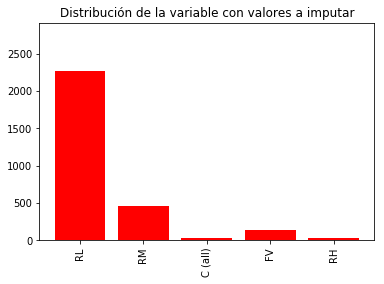

In [51]:
freq_table = no_miss_MSZ.select('MSZoning').rdd.map(lambda row: row.MSZoning).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

Podríamos asignarle a los 4 valores missing la **categoría mayoritaria**, es decir, **RL**.

* **Analizamos otra manera de hacerlo, quizás más laboriosa y aprovechando la información de otras variables**

La variable a imputar, **MSZoning**, se trata de una variable categórica que hace referencia al tipo de zona en la que se encuentra el hogar en venta. Ahora bien, **¿tiene relación la zona en la que se encuentra una vivienda y el tipo de vivienda que es?** Parece que tiene sentido que, usando la variable **MSSubClass**, que identifica el tipo de vivienda involucrada en la venta, podamos conocer el tipo de zona en la que se encuentra la vivienda.

Así, calculamos el tipo de vivienda más frecuente asociada a cada zona. Posteriormente, conociendo el tipo de vivienda que presentan los registros con valor faltante en la variable a imputar, podemos conocer la zona que le correspondería.

> En primer lugar agrupamos las observaciones por las variables 'MSSubClass', 'MSZoning' y analizamos el conteo de cada combinación posible.

In [52]:
Group_MSZ_MSS = no_miss_MSZ.groupBy('MSSubClass', 'MSZoning').agg(F.count('MSZoning').alias("MSZoningCount"))
Group_MSZ_MSS.show()

+----------+--------+-------------+
|MSSubClass|MSZoning|MSZoningCount|
+----------+--------+-------------+
|        60|      FV|           43|
|       180|      RM|           17|
|        20|      FV|           34|
|        30|      RH|            2|
|        45|      RM|           11|
|        50|      RH|            2|
|       160|      FV|           43|
|        45|      RH|            1|
|        80|      RM|            3|
|       190|      RM|           23|
|        20|      RM|           20|
|        40|      RM|            2|
|       160|      RM|           64|
|        45|      RL|            6|
|        40|      RL|            4|
|       160|      RL|           21|
|        90|      RM|           13|
|        90|      RL|           92|
|       150|      RL|            1|
|       190| C (all)|            3|
+----------+--------+-------------+
only showing top 20 rows



> Usaremos ahora la función `Window()` del módulo `pyspark.sql.window` para conocer el valor mázimo de la nueva variable calculada según la variable `MSSubClas'.

In [53]:
maxWindow = Window.partitionBy('MSSubClass')
maxColumn = F.max(F.col('MSZoningCount')).over(maxWindow)
Group_MSZ_MSS_Max = Group_MSZ_MSS.withColumn('maxMSZoningCount', maxColumn)

> Por último, accedemos a aquel registro en el que las dos nuevas variables coinciden en valor. Así, tendremos para cada posible categoría de la variable 'MSSubClass', es decir, para cada posible tipo de vivienda, la zona más frecuente.

In [54]:
df_mode_MSZ_MSS = Group_MSZ_MSS_Max.filter((F.col('maxMSZoningCount') - F.col('MSZoningCount')) == 0) \
    .select('MSSubClass', 'MSZoning').sort(F.asc('MSSubClass'))

df_mode_MSZ_MSS = df_mode_MSZ_MSS.withColumnRenamed('MSZoning', 'MSZoning_freq')

df_mode_MSZ_MSS.show()

+----------+-------------+
|MSSubClass|MSZoning_freq|
+----------+-------------+
|        20|           RL|
|        30|           RM|
|        40|           RL|
|        45|           RM|
|        50|           RL|
|        60|           RL|
|        70|           RM|
|        75|           RM|
|        80|           RL|
|        85|           RL|
|        90|           RL|
|       120|           RL|
|       150|           RL|
|       160|           RM|
|       180|           RM|
|       190|           RL|
+----------+-------------+



Ahora, tendríamos que analizar qué tipo de vivienda presentan los hogares con valor faltante en la variable 'MSZoning':

In [55]:
miss_MSZ.select('MSZoning', 'MSSubClass').show()

+--------+----------+
|MSZoning|MSSubClass|
+--------+----------+
|    null|        30|
|    null|        20|
|    null|        70|
|    null|        20|
+--------+----------+



Luego ya estamos en disposición de realizar la imputación. Previamente a ello incluimos una nueva variable que sea el índice de los registros para así luego comprobar que la imputación ha sido correcta.

In [56]:
from pyspark.sql.functions import monotonically_increasing_id

full_df = full_df.withColumn("index", monotonically_increasing_id())

In [57]:
full_df.filter(F.col('MSZoning').isNull()).select('MSZoning', 'MSSubClass', 'index').show()

+--------+----------+----------+
|MSZoning|MSSubClass|     index|
+--------+----------+----------+
|    null|        30|8589935047|
|    null|        20|8589935348|
|    null|        70|8589935382|
|    null|        20|8589936036|
+--------+----------+----------+



Por tanto:
    
* A los registros con valor 20 en la variable 'MSSubClass' se les asignará la categoría **RL**.
* A los registros con valor 30 y 70, presentarán la categoría **RM**.

Realizamos el tratamiento de los valores missing:

In [58]:
full_df = full_df.join(df_mode_MSZ_MSS, 'MSSubClass').withColumn('MSZoning', F.when(F.col('MSZoning').isNull(),
                                                                                    F.col('MSZoning_freq')).\
                                                                 otherwise(F.col('MSZoning'))).drop('MSZoning_freq')

In [59]:
full_df.filter((F.col('index') == 8589935047) | (F.col('index') == 8589935348) |
               (F.col('index') == 8589935382) | (F.col('index') == 8589936036)).select('MSZoning', 'MSSubClass', 'index').show()

+--------+----------+----------+
|MSZoning|MSSubClass|     index|
+--------+----------+----------+
|      RL|        20|8589935348|
|      RL|        20|8589936036|
|      RM|        70|8589935382|
|      RM|        30|8589935047|
+--------+----------+----------+



Observamos que el reemplazamiento ha sido correcto.

**Utilities - 2 registros faltantes**

In [60]:
new_full_df_drop.filter(F.col('Column_Name') == "Utilities").show()

+-----------+----------+
|Column_Name|NULL_Count|
+-----------+----------+
|  Utilities|         2|
+-----------+----------+



In [61]:
miss_util = full_df.filter(full_df.Utilities.isNull())
miss_util.select(miss_util.columns[:12]).show()

no_miss_util = full_df.filter(full_df.Utilities.isNotNull())
print("Hay un total de {} filas con valor en la variable dada.".format(no_miss_util.count()))

+----------+------------+----+--------+----------------+-------+------+--------+-----------+---------+---------+---------+
|MSSubClass|Neighborhood|  Id|MSZoning|     LotFrontage|LotArea|Street|LotShape|LandContour|Utilities|LotConfig|LandSlope|
+----------+------------+----+--------+----------------+-------+------+--------+-----------+---------+---------+---------+
|        20|     Gilbert|1946|      RL|74.2072072072072|  31220|  Pave|     IR1|        Bnk|     null|      FR2|      Gtl|
|        30|      IDOTRR|1916|      RM|           109.0|  21780|  Grvl|     Reg|        Lvl|     null|   Inside|      Gtl|
+----------+------------+----+--------+----------------+-------+------+--------+-----------+---------+---------+---------+

Hay un total de 2917 filas con valor en la variable dada.


Recordamos la clase de dicha variable:

In [62]:
no_miss_util.select('Utilities').printSchema()

root
 |-- Utilities: string (nullable = true)



In [63]:
no_miss_util.groupBy('Utilities').count().show()

+---------+-----+
|Utilities|count|
+---------+-----+
|   NoSeWa|    1|
|   AllPub| 2916|
+---------+-----+



Observamos que hay un claro predominio de una de las dos clases. Debido a que la variable a imputar sus registros missing es prácticamente constante, no influirá en demasia en la predicción del modelo predictivo (la observación pertenece a la muestra de entrenamiento ya que tiene valor en la variable objetivo) luego podemos eliminarla.

In [64]:
no_miss_util.filter(F.col('Utilities') == 'NoSeWa').select('SalePrice').show()

+---------+
|SalePrice|
+---------+
|   137500|
+---------+



In [65]:
full_df = full_df.drop('Utilities')

**Exterior1st - 1 registro faltante** & **Exterior2nd - 1 registro faltante**

In [66]:
new_full_df_drop.filter((F.col('Column_Name') == "Exterior1st") | (F.col('Column_Name') == "Exterior2nd")).show()

+-----------+----------+
|Column_Name|NULL_Count|
+-----------+----------+
|Exterior1st|         1|
|Exterior2nd|         1|
+-----------+----------+



In [67]:
miss_ext = full_df.filter(full_df['Exterior1st'].isNull())
miss_ext.select(miss_ext.columns[21:30]).show()

no_miss_ext = full_df.filter(full_df['Exterior1st'].isNotNull())
print("Hay un total de {} filas con valor en la variable dada.".format(no_miss_ext.count()))

+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+
|Exterior1st|Exterior2nd|MasVnrType|MasVnrArea|ExterQual|ExterCond|Foundation|BsmtQual|BsmtCond|
+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+
|       null|       null|      None|         0|       TA|       TA|     PConc|      TA|      TA|
+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+

Hay un total de 2918 filas con valor en la variable dada.


Observamos que es el mismo individuo el que presenta el registro nulo en ambas variables. Analizamos ahora la categoría de ambas variables:

In [68]:
full_df.select('Exterior1st', 'Exterior2nd').printSchema()

root
 |-- Exterior1st: string (nullable = true)
 |-- Exterior2nd: string (nullable = true)



Analizamos ahora la frecuencia de cada una de las subcategorías de cada variable categórica:

In [69]:
no_miss_ext.groupBy('Exterior1st').count().sort(F.desc('count')).show()

+-----------+-----+
|Exterior1st|count|
+-----------+-----+
|    VinylSd| 1025|
|    MetalSd|  450|
|    HdBoard|  442|
|    Wd Sdng|  411|
|    Plywood|  221|
|    CemntBd|  126|
|    BrkFace|   87|
|    WdShing|   56|
|    AsbShng|   44|
|     Stucco|   43|
|    BrkComm|    6|
|    AsphShn|    2|
|     CBlock|    2|
|      Stone|    2|
|    ImStucc|    1|
+-----------+-----+



In [70]:
no_miss_ext.groupBy('Exterior2nd').count().sort(F.desc('count')).show()

+-----------+-----+
|Exterior2nd|count|
+-----------+-----+
|    VinylSd| 1014|
|    MetalSd|  447|
|    HdBoard|  406|
|    Wd Sdng|  391|
|    Plywood|  270|
|    CmentBd|  126|
|    Wd Shng|   81|
|     Stucco|   47|
|    BrkFace|   47|
|    AsbShng|   38|
|    Brk Cmn|   22|
|    ImStucc|   15|
|      Stone|    6|
|    AsphShn|    4|
|     CBlock|    3|
|      Other|    1|
+-----------+-----+



Reemplazamos ambos registros nulos por la **moda**, es decir, la categoría más frecuente: **VinylSd**

In [71]:
imputed_Ext1 = 'VinylSd'
imputed_Ext2 = 'VinylSd'

full_df = full_df.fillna({'Exterior1st': imputed_Ext1, 'Exterior2nd': imputed_Ext2})

**Variables que miden los años de construcción: YearBuilt, YearRemodAdd**

Si el hogar no ha sido modificado, el año en la segunda variable coincide con el de la primera. En el apartado de **ingeniería de atributos** veremos cómo tratar con estos dos atributos.

In [72]:
full_df.select('YearBuilt', 'YearRemodAdd').show()

+---------+------------+
|YearBuilt|YearRemodAdd|
+---------+------------+
|     1983|        1983|
|     1978|        1978|
|     2003|        2003|
|     1996|        1996|
|     1970|        1970|
|     1982|        1982|
|     1963|        1963|
|     1972|        1972|
|     1982|        1982|
|     1978|        1978|
|     1975|        1981|
|     1961|        1995|
|     1972|        2003|
|     1961|        2007|
|     1992|        1992|
|     1962|        1962|
|     1974|        1974|
|     1967|        1967|
|     1972|        2007|
|     1966|        1966|
+---------+------------+
only showing top 20 rows



**Variables Garage**

Dentro de este grupo de variables distinguimos dos tipos:
* **Variables cuantitativas (GarageYrBlt, GarageArea, GarageCars)**: cuyos valores missing serán reemplazados por 0 haciendo referencia a que dicho hogar no presentaba garage.
* **Variables cualitativas (GarageType, GarageFinish, GarageQual, GarageCond)**: cuyos valores missing serán reemplazados por None.

* **Variables cuantitativas**

Analizamos los valores missing de dichas variables:

In [73]:
new_full_df_drop.filter((F.col('Column_Name') == "GarageYrBlt") |
                       (F.col('Column_Name') == "GarageArea") |
                       (F.col('Column_Name') == "GarageCars")).show()

+-----------+----------+
|Column_Name|NULL_Count|
+-----------+----------+
|GarageYrBlt|       159|
| GarageCars|         1|
| GarageArea|         1|
+-----------+----------+



In [74]:
full_df.filter(F.col('GarageCars').isNull()).select('GarageYrBlt', 'GarageCars', 'GarageArea').show()

+-----------+----------+----------+
|GarageYrBlt|GarageCars|GarageArea|
+-----------+----------+----------+
|       null|      null|      null|
+-----------+----------+----------+



Vemos que tiene sentido suponer que aquel registro que presenta un valor nulo en las tres variables cuantitativas: 'GarageCars', 'GarageArea' y 'GarageYrBlt' se debe a que dicho hogar no tenía garage y podemos asignarle el valor 0.

Pero bien, **¿qué ocurre con aquellos registros con valor nulo en la variable GarageYrBlt?**

In [75]:
full_df.filter(F.col('GarageYrBlt').isNull()).select('GarageYrBlt', 'GarageCars', 'GarageArea').show(5)

+-----------+----------+----------+
|GarageYrBlt|GarageCars|GarageArea|
+-----------+----------+----------+
|       null|         0|         0|
|       null|         0|         0|
|       null|         0|         0|
|       null|         0|         0|
|       null|         0|         0|
+-----------+----------+----------+
only showing top 5 rows



In [76]:
full_df.filter(((F.col('GarageYrBlt').isNull()) & (F.col('GarageCars') != 0)) \
    | ((F.col('GarageYrBlt').isNull()) & (F.col('GarageArea') != 0))) \
               .select('GarageYrBlt', 'GarageCars', 'GarageArea', 'index').show()

+-----------+----------+----------+----------+
|GarageYrBlt|GarageCars|GarageArea|     index|
+-----------+----------+----------+----------+
|       null|         1|       360|8589935258|
+-----------+----------+----------+----------+



**Conclusión:** Tras un primer análisis veíamos que predominaba el hecho de que cuando la variable 'GarageYrBlt' presentaba un registro nulo, las demás variables tenían un valor 0 (volviendo al caso de la no existencia de garage en la casa). Así, se nos ocurre la idea de conocer cuántos hogares, sin fecha de garage, presentan datos numéricos sobre los mismos. El resultado alcanzado es que es sólo un individuo (de un total de 159) el que presenta dicha característica.

Así, decidimos eliminar dicho registro de nuestro set de datos y reemplazar por **0** todos los valores missing restantes de las tres variables.

In [77]:
full_df = full_df.filter(full_df['index'] != 8589935258)

In [78]:
print("Número de registros de nuestro set de datos:", full_df.count())

Número de registros de nuestro set de datos: 2918


In [79]:
imputed_garage = 0

full_df = full_df.fillna({'GarageYrBlt': imputed_garage, 'GarageArea': imputed_garage, 'GarageCars': imputed_garage})

* **Variables cualitativas**

In [80]:
new_full_df_drop.filter((F.col('Column_Name') == "GarageType") |
                       (F.col('Column_Name') == "GarageFinish") |
                       (F.col('Column_Name') == "GarageQual") |
                       (F.col('Column_Name') == "GarageCond")).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|  GarageType|       157|
|GarageFinish|       159|
|  GarageQual|       159|
|  GarageCond|       159|
+------------+----------+



Observamos que practicamente, las 4 variables presentan el mismo número de valores missing.

In [81]:
full_df.filter(((F.col('GarageFinish').isNull()) & (F.col('GarageQual').isNotNull())) \
              | ((F.col('GarageFinish').isNull()) & (F.col('GarageCond').isNotNull()))).count()

0

Vemos que las tres variables con el mismo número de valores missing coinciden en los individuos que las presentan. **¿Qué hacemos ante este caso?** Pues bien, reemplazaremos dichos valores missing por 'None' haciendo referencia a que no extiste garage en dicha instancia. Dichas variables presentaban la categoría 'NA' que fue reemplazado por valores missing, lo cual significa la ausencia de garage en la casa luego tiene sentido el reemplazamiento por el valor 'None'.

In [82]:
imputed_garage_2 = 'None'

full_df = full_df.fillna({'GarageFinish': imputed_garage_2, 'GarageQual': imputed_garage_2, 
                         'GarageCond': imputed_garage_2, 'GarageType': imputed_garage_2})

Es momento de recordar los registros missing que nos quedan por comentar:

In [83]:
new_full_df = full_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns])

new_full_df_drop = count_nulls_df(new_full_df)
new_full_df_drop.filter((F.col('Column_Name') != 'SalePrice') & (F.col('NULL_Count') >=1)).sort(F.desc('NULL_Count')).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|BsmtExposure|        82|
|    BsmtCond|        82|
|    BsmtQual|        81|
|BsmtFinType2|        80|
|BsmtFinType1|        79|
|  MasVnrType|        24|
|  MasVnrArea|        23|
|BsmtHalfBath|         2|
|  Functional|         2|
|BsmtFullBath|         2|
|  BsmtFinSF1|         1|
|  BsmtFinSF2|         1|
|  Electrical|         1|
|    SaleType|         1|
| TotalBsmtSF|         1|
| KitchenQual|         1|
|   BsmtUnfSF|         1|
+------------+----------+



**Variables que evalúan el sótano de la casa: BsmtCond, BsmtExposure, BsmtQual, BsmtFinType2, BsmtFinType1**

La descripción de dichas variables (categóricas todas ellas) es la que sigue:

* **BsmtCond**: Evalúa el estado general del sótano.
* **BsmtExposure**: Se refiere al nivel del jardín.
* **BsmtQual**: Evalúa la altura del sótano.
* **BsmtFinType1**: Clasificación del sótano.
* **BsmtFinType2**: Clasificación del sótano (si hay varios).

Todas estas variables presentan una categoría denominada **'NA'** la cual hace referencia a la no existencia de sótano. En el comienzo del trabajo nos percatamos de la existencia de dichos valores y decidimos reemplazarlos por valores faltantes 'null'. En este caso, no se trata de registros faltantes sino de la no existencia del establecimiento.

Por tanto, nuestra tarea seará sustituir dichos valores por **'None'** de manera análoga a como lo hicimos con las variables que hacían referencia al garage.

In [84]:
c = "Column_Name"
full_df_count_NA_col.filter((F.col(c) == 'BsmtCond') | (F.col(c) == 'BsmtExposure') | (F.col(c) == 'BsmtQual') | 
                            (F.col(c) == 'BsmtFinType1') | (F.col(c) == 'BsmtFinType2')).show()

+------------+--------+
| Column_Name|NA_Count|
+------------+--------+
|    BsmtQual|      81|
|    BsmtCond|      82|
|BsmtExposure|      82|
|BsmtFinType1|      79|
|BsmtFinType2|      80|
+------------+--------+



* Vemos que dichas variables no presentaban registros missing antes del reemplazamiento de los valores 'NA'. Así, lo que hemos hecho simplemente es cambiarle la categoría a 'None'.

In [85]:
imputed_basement = 'None'

full_df = full_df.fillna({'BsmtCond': imputed_basement, 'BsmtExposure': imputed_basement, 
                         'BsmtQual': imputed_basement, 'BsmtFinType1': imputed_basement, 'BsmtFinType2': imputed_basement})

**Variables: MasVnrType y MasVnrArea**

Se tratan de variables relacionadas con el proceso de construcción de la casa. Más estrictamente hace referencia a una capa externa no estructural de mampostería, típicamente hecha de ladrillo, piedra o piedra manufacturada. 

In [86]:
full_df.filter((F.col('MasVnrType').isNull()) & (F.col('MasVnrArea').isNotNull())).count()

1

Vemos que existe un único registro del cual conocemos el área y no el tipo de chapa utilizada. El resto de observaciones que no presentan uno de los dos valores, también se desconoce el otro.

In [87]:
no_miss_VnType = full_df.filter(F.col('MasVnrType').isNotNull())

no_miss_VnType.groupBy('MasVnrType').count().sort(F.desc('count')).show()

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None| 1741|
|   BrkFace|  879|
|     Stone|  249|
|    BrkCmn|   25|
+----------+-----+



Observamos que una de las categorías de la variable categórica es 'None', indicando que se deconoce ese dato o que no presenta dicha característica dicho hogar.

Analizamos a continuación la relación existente entre ambas variables:

In [88]:
full_df.filter((F.col('MasVnrType') == "None") & (F.col('MasVnrArea') == 0)).count()

1734

* Vemos que existen 7 casos en los que el tipo de la capa de anclaje se desconoce. Sabemos que se desconoce (y no que no existe) pues la variable que mide su área es distinta de cero.

In [89]:
full_df.filter((F.col('MasVnrArea') == 0)).groupBy('MasVnrType').count().show()

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None| 1734|
|     Stone|    1|
|   BrkFace|    2|
+----------+-----+



* Por otro lado, de los 1737 casos en los que el área de la capa externa en metros cuadrados es 0, 1734 de ellos presentaban el valor 'None' en la otra variable, lógicamente.

Observamos que hay un claro predominio de casos en los que las casas no han sido recubiertas con dicha capa de mampostería (son los casos en los que la variable tipo es 'None' y el area 0). Debido a dicho predominio, decidimos reemplazar los registros faltantes de ambas variables del siguiente modo: los valores missing de la variable **MasVnrType** serán reemplazados por la categoría **None** (no existe dicha capa de anclaje o se desconoce su tipo) y los registros faltantes de la otra variable, **MasVnrArea**, serán sustituidos por el valor 0 ya que es el caso más habitual considerando ambas variables.

In [90]:
imputed_VnrType = 'None'
imputed_VnrArea = 0

full_df = full_df.fillna({'MasVnrType': imputed_VnrType, 'MasVnrArea': imputed_VnrArea})

In [91]:
new_full_df = full_df.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns])

new_full_df_drop = count_nulls_df(new_full_df)
new_full_df_drop.filter((F.col('Column_Name') != 'SalePrice') & (F.col('NULL_Count') >=1)).sort(F.desc('NULL_Count')).show()

+------------+----------+
| Column_Name|NULL_Count|
+------------+----------+
|BsmtFullBath|         2|
|BsmtHalfBath|         2|
|  Functional|         2|
|   BsmtUnfSF|         1|
|  BsmtFinSF2|         1|
|  BsmtFinSF1|         1|
| TotalBsmtSF|         1|
|  Electrical|         1|
| KitchenQual|         1|
|    SaleType|         1|
+------------+----------+



**Imputación del resto de valores missing**

Tras una amplia descripción y análisis de una serie de variables con su cosiguiente preprocesamiento, nos disponemos a reemplazar los restantes registros faltantes del siguiente modo: los valores missing de las variables categóricas serán reemplazados por su valor más frecuente, mientras que los correspondientes a las variables numéricas se les asociará el valor 0.

In [92]:
full_df.select('BsmtHalfBath', 'BsmtFullBath', 'Functional', 'TotalBsmtSF', 'BsmtFinSF1', 
              'BsmtUnfSF', 'BsmtFinSF2', 'Electrical', 'KitchenQual', 'SaleType').printSchema()

root
 |-- BsmtHalfBath: integer (nullable = true)
 |-- BsmtFullBath: integer (nullable = true)
 |-- Functional: string (nullable = true)
 |-- TotalBsmtSF: integer (nullable = true)
 |-- BsmtFinSF1: integer (nullable = true)
 |-- BsmtUnfSF: integer (nullable = true)
 |-- BsmtFinSF2: integer (nullable = true)
 |-- Electrical: string (nullable = true)
 |-- KitchenQual: string (nullable = true)
 |-- SaleType: string (nullable = true)



Las variables numéricas hacen referencia al sótano de la casa. Anteriormente veíamos que había variables que medían aspectos cualitativos del sótano y se les asociaba el valor 'None' haciendo referencia a la no existencia de sótano en el registro en cuestión. El razonamiento por el cual en este caso se les asigna el valor 0 es análogo, podríamos reemplazar dichos valores missing por la media o la mediana, sin embargo, tiene más sentido asignarles el valor 0 significando así que no existen medidas numéricas que midan aspectos del sótano debido a la no presencia del mismo.

In [93]:
imputed_integer = 0

full_df = full_df.fillna({'BsmtHalfBath': imputed_integer, 'BsmtFullBath': imputed_integer, 'TotalBsmtSF': imputed_integer, 
                        'BsmtFinSF1': imputed_integer, 'BsmtUnfSF': imputed_integer, 'BsmtFinSF2': imputed_integer})

* **Variables categóricas: Functional, Electrical, KitchenQual, SaleType**

> Reemplazaremos los valores missing de dichas variables categóricas usando la categoría más frecuente de cada una de ellas.

In [94]:
full_df.filter(F.col('Functional').isNotNull()).groupBy('Functional').count().show()

+----------+-----+
|Functional|count|
+----------+-----+
|      Maj1|   19|
|       Sev|    2|
|      Min2|   70|
|      Min1|   65|
|       Typ| 2716|
|      Maj2|    9|
|       Mod|   35|
+----------+-----+



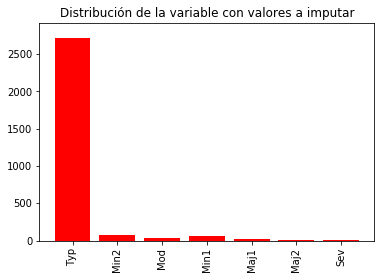

In [95]:
freq_table = full_df.filter(F.col('Functional').isNotNull()).select('Functional').rdd.map(lambda row: 
                                                                                          row.Functional).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

In [96]:
imputed_Functional = "Typ"

In [97]:
full_df.filter(full_df.Electrical.isNotNull()).groupBy('Electrical').count().show()

+----------+-----+
|Electrical|count|
+----------+-----+
|       Mix|    1|
|     FuseF|   50|
|     SBrkr| 2670|
|     FuseP|    8|
|     FuseA|  188|
+----------+-----+



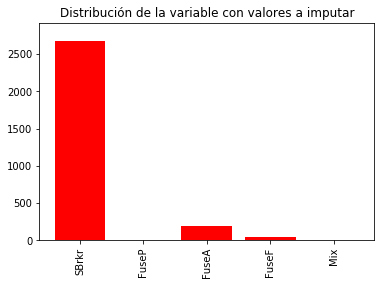

In [98]:
freq_table = full_df.filter(F.col('Electrical').isNotNull()).select('Electrical').rdd.map(lambda row: 
                                                                                          row.Electrical).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

In [99]:
imputed_Electrical = "SBrkr"

In [100]:
full_df.filter(full_df['KitchenQual'].isNotNull()).groupBy('KitchenQual').count().show()

+-----------+-----+
|KitchenQual|count|
+-----------+-----+
|         Gd| 1151|
|         Ex|  205|
|         Fa|   70|
|         TA| 1491|
+-----------+-----+



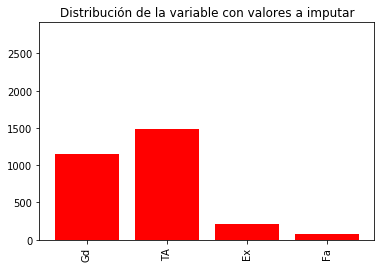

In [101]:
freq_table = full_df.filter(F.col('KitchenQual').isNotNull()).select('KitchenQual').rdd.map(lambda row: 
                                                                                          row.KitchenQual).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

In [102]:
imputed_Kitchen = "TA"

In [103]:
full_df.filter(F.col('SaleType').isNotNull()).groupBy('SaleType').count().show()

+--------+-----+
|SaleType|count|
+--------+-----+
|   ConLD|   26|
|     COD|   87|
|     Con|    5|
|     Oth|    7|
|   ConLI|    9|
|     CWD|   12|
|   ConLw|    8|
|      WD| 2524|
|     New|  239|
+--------+-----+



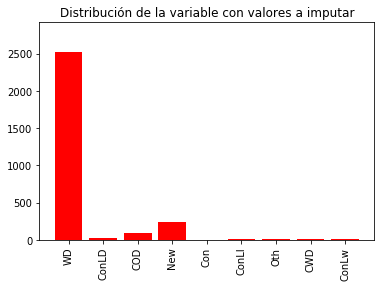

In [104]:
freq_table = full_df.filter(F.col('SaleType').isNotNull()).select('SaleType').rdd.map(lambda row: 
                                                                                          row.SaleType).countByValue()
plot_freqs(freq_table.keys(), freq_table.values(), sum(freq_table.values()))

In [105]:
imputed_SaleType = "WD"

Así, reemplazmos cada registro nulo de nuestras variables categóricas:

In [106]:
full_df = full_df.fillna({'Functional': imputed_Functional, 'Electrical': imputed_Electrical, 
                         'KitchenQual': imputed_Kitchen, 'SaleType': imputed_SaleType})

**Comprobación**

Comprobamos que ya no tenemos ningún registro missing.

In [107]:
df_null = full_df.select(*(F.sum(F.col(c).isNull().cast(IntegerType())).alias(c) for c in full_df.columns)).toPandas()
df_null

print("El número de registros faltantes de las variables explicativas es:", df_null.iloc[0,:].sum() - 1458)

El número de registros faltantes de las variables explicativas es: 0


Eliminamos las variables **Id** y **index** pues son un simple identificador de los registros:

In [108]:
full_df = full_df.drop('Id', 'index')

Guardamos nuestro dataset limpio de valores missing:

In [109]:
full_df.toPandas().to_csv('dataset_clean.csv')

## Descripción del dataset

In [110]:
full_df.select([c for c in full_df.columns]).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
MSSubClass,2918,57.13673749143249,42.52488207374578,20,190
Neighborhood,2918,None,None,Blmngtn,Veenker
MSZoning,2918,None,None,C (all),RM
LotFrontage,2918,69.96671659318025,21.721780303740797,21.0,313.0
LotArea,2918,10168.824880054832,7888.254633961419,1300,215245
Street,2918,None,None,Grvl,Pave
LotShape,2918,None,None,IR1,Reg
LandContour,2918,None,None,Bnk,Lvl
LotConfig,2918,None,None,Corner,Inside


## Ingeniería de atributos

### Variables que miden el área de la casa: TotalBsmtSF, 1stFlrSF, 2ndFlrSF

El significado de dichas variables es el que sigue:

* **TotalBsmtSF**: área sótano
* **1stFlrSF**: área primera planta
* **2ndFlrSF**: área segunda planta

El trato de dichas variables va a ser el siguiente: tiene sentido crear una variable que haga referencia al área total de la casa que sería la suma de los valores de las tres variables mencionadas.

In [111]:
full_df = full_df.withColumn('TotalSF', F.col('TotalBsmtSF') + F.col('1stFlrSF') + F.col('2ndFlrSF'))

Ahora bien, observamos que la suma de las variables **BsmtFinSF1**, **BsmtFinSF2** y **BsmtUnfSF** da lugar a la variable **TotalBsmtSF** que mide el área total del sótano. Tiene sentido pues las anteriores variables medían el área del sótano de tipo 1, de tipo 2 y el no terminado, respectivamente. Así, parece tener sentido eliminar dichas tres variables.

In [112]:
full_df.filter(F.col('TotalBsmtSF') != (F.col('BsmtFinSF1') + F.col('BsmtFinSF2') + F.col('BsmtUnfSF'))).count()

0

In [113]:
full_df.select('TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF').show(5)

+-----------+----------+----------+---------+
|TotalBsmtSF|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|
+-----------+----------+----------+---------+
|        840|       747|        93|        0|
|        888|       773|         0|      115|
|          0|         0|         0|        0|
|        870|       298|         0|      572|
|        768|       619|         0|      149|
+-----------+----------+----------+---------+
only showing top 5 rows



Así, decidimos eliminar las variables 'BsmtFinSF1', 'BsmtFinSF2' y 'BsmtUnfSF' puesto que hemos existe una variable que nos aporta la información de las tres y así reducimos nuestro espacio predictor.

In [114]:
full_df = full_df.drop('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF')

Además, hemos creado una variable, 'TotalSF', que mide el área total de la casa. Así, con el fin de reducir la dimensionalidad, eliminaremos las variables que nos daban el área total de cada planta de la casa puesto que tenemos una variable que nos sirve como resumen de las anteriores.

In [115]:
full_df = full_df.drop('TotalBsmtSF', '1stFlrSF', '2ndFlrSF')

### Variables con información acerca de los baños de la casa

Hay 4 variables con información acerca del baño: **FullBath**, **HalfBath**, **BsmtFullBath** y **BsmtHalfBath**. Dichas variables miden el número total de baños del hogar y nuestra tarea será crear un predictor que mida el número total de los baños. Estas variables individualmente no presentan una gran influencia, sin embargo, añadiendo todas en ellas en un único predictor podemos encontrar un predictor fuerte en nuestro modelo y con ello, reducimos la dimensionalidad de nuestro conjunto de variables explicativas. 

Ahora bien, **¿qué entendemos por 'half bath'?**, pues se trata de baños que presentan la mitad de compartimentos básicos de un baño, así, contaremos dichos baños como medio a la hora de elaborar nuestro predictor.

In [116]:
full_df = full_df.withColumn('TotalBath', 
                             F.col('FullBath') + 0.5*F.col('HalfBath') + F.col('BsmtFullBath') + 0.5*F.col('BsmtHalfBath'))

### Variables relacionadas con el año de contrucción/remodelación de la casa

En el apartado de imputación de valores missing observamos la presencia de dos variables numéricas que establecían el año en el que el hogar se había construído así como el año en el que el hogar se había remodelado (siendo el mismo si dicha condición no se daba). Así, y junto a la variable **YrSold**, podemos determinar la antigüedad de la casa y si la casa ha sufrido modificaciones o no.

Consideraremos las variables **YrSold** y **YearRemodAdd** para determinar la edad del edificio, **AgeHouse**, y construiremos una variable binaria **RemodHouse** (1 Yes, 0 No) atendiendo a si la casa ha sido remodelada.

In [117]:
full_df = full_df \
    .withColumn('RemodHouse', F.when(full_df['YearBuilt'] == full_df['YearRemodAdd'], 0).otherwise(1)) \
    .withColumn('AgeHouse', F.col('YrSold') - F.col('YearRemodAdd'))

Eliminamos los atributos a partir de los cuales hemos creado los nuevos predictores:

In [118]:
full_df = full_df.drop('YearBuilt', 'YearRemodAdd', 'YrSold', 
                      'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath')

In [119]:
print("El número de variables de nuestro conjunto de datos es:", len(full_df.columns))

El número de variables de nuestro conjunto de datos es: 65


# Preparación del dataset para el modelado
---

## Visualización de la matriz de correlación (variables numéricas)

Si estuviesemos interesados en elaborar un modelo de regresión lineal podría ser interesante calcular la matriz de correlaciones y eliminar aquellas variables que se encuentren altamente correladas con otra variable lo que añadiría ruido a nuestro modelo..

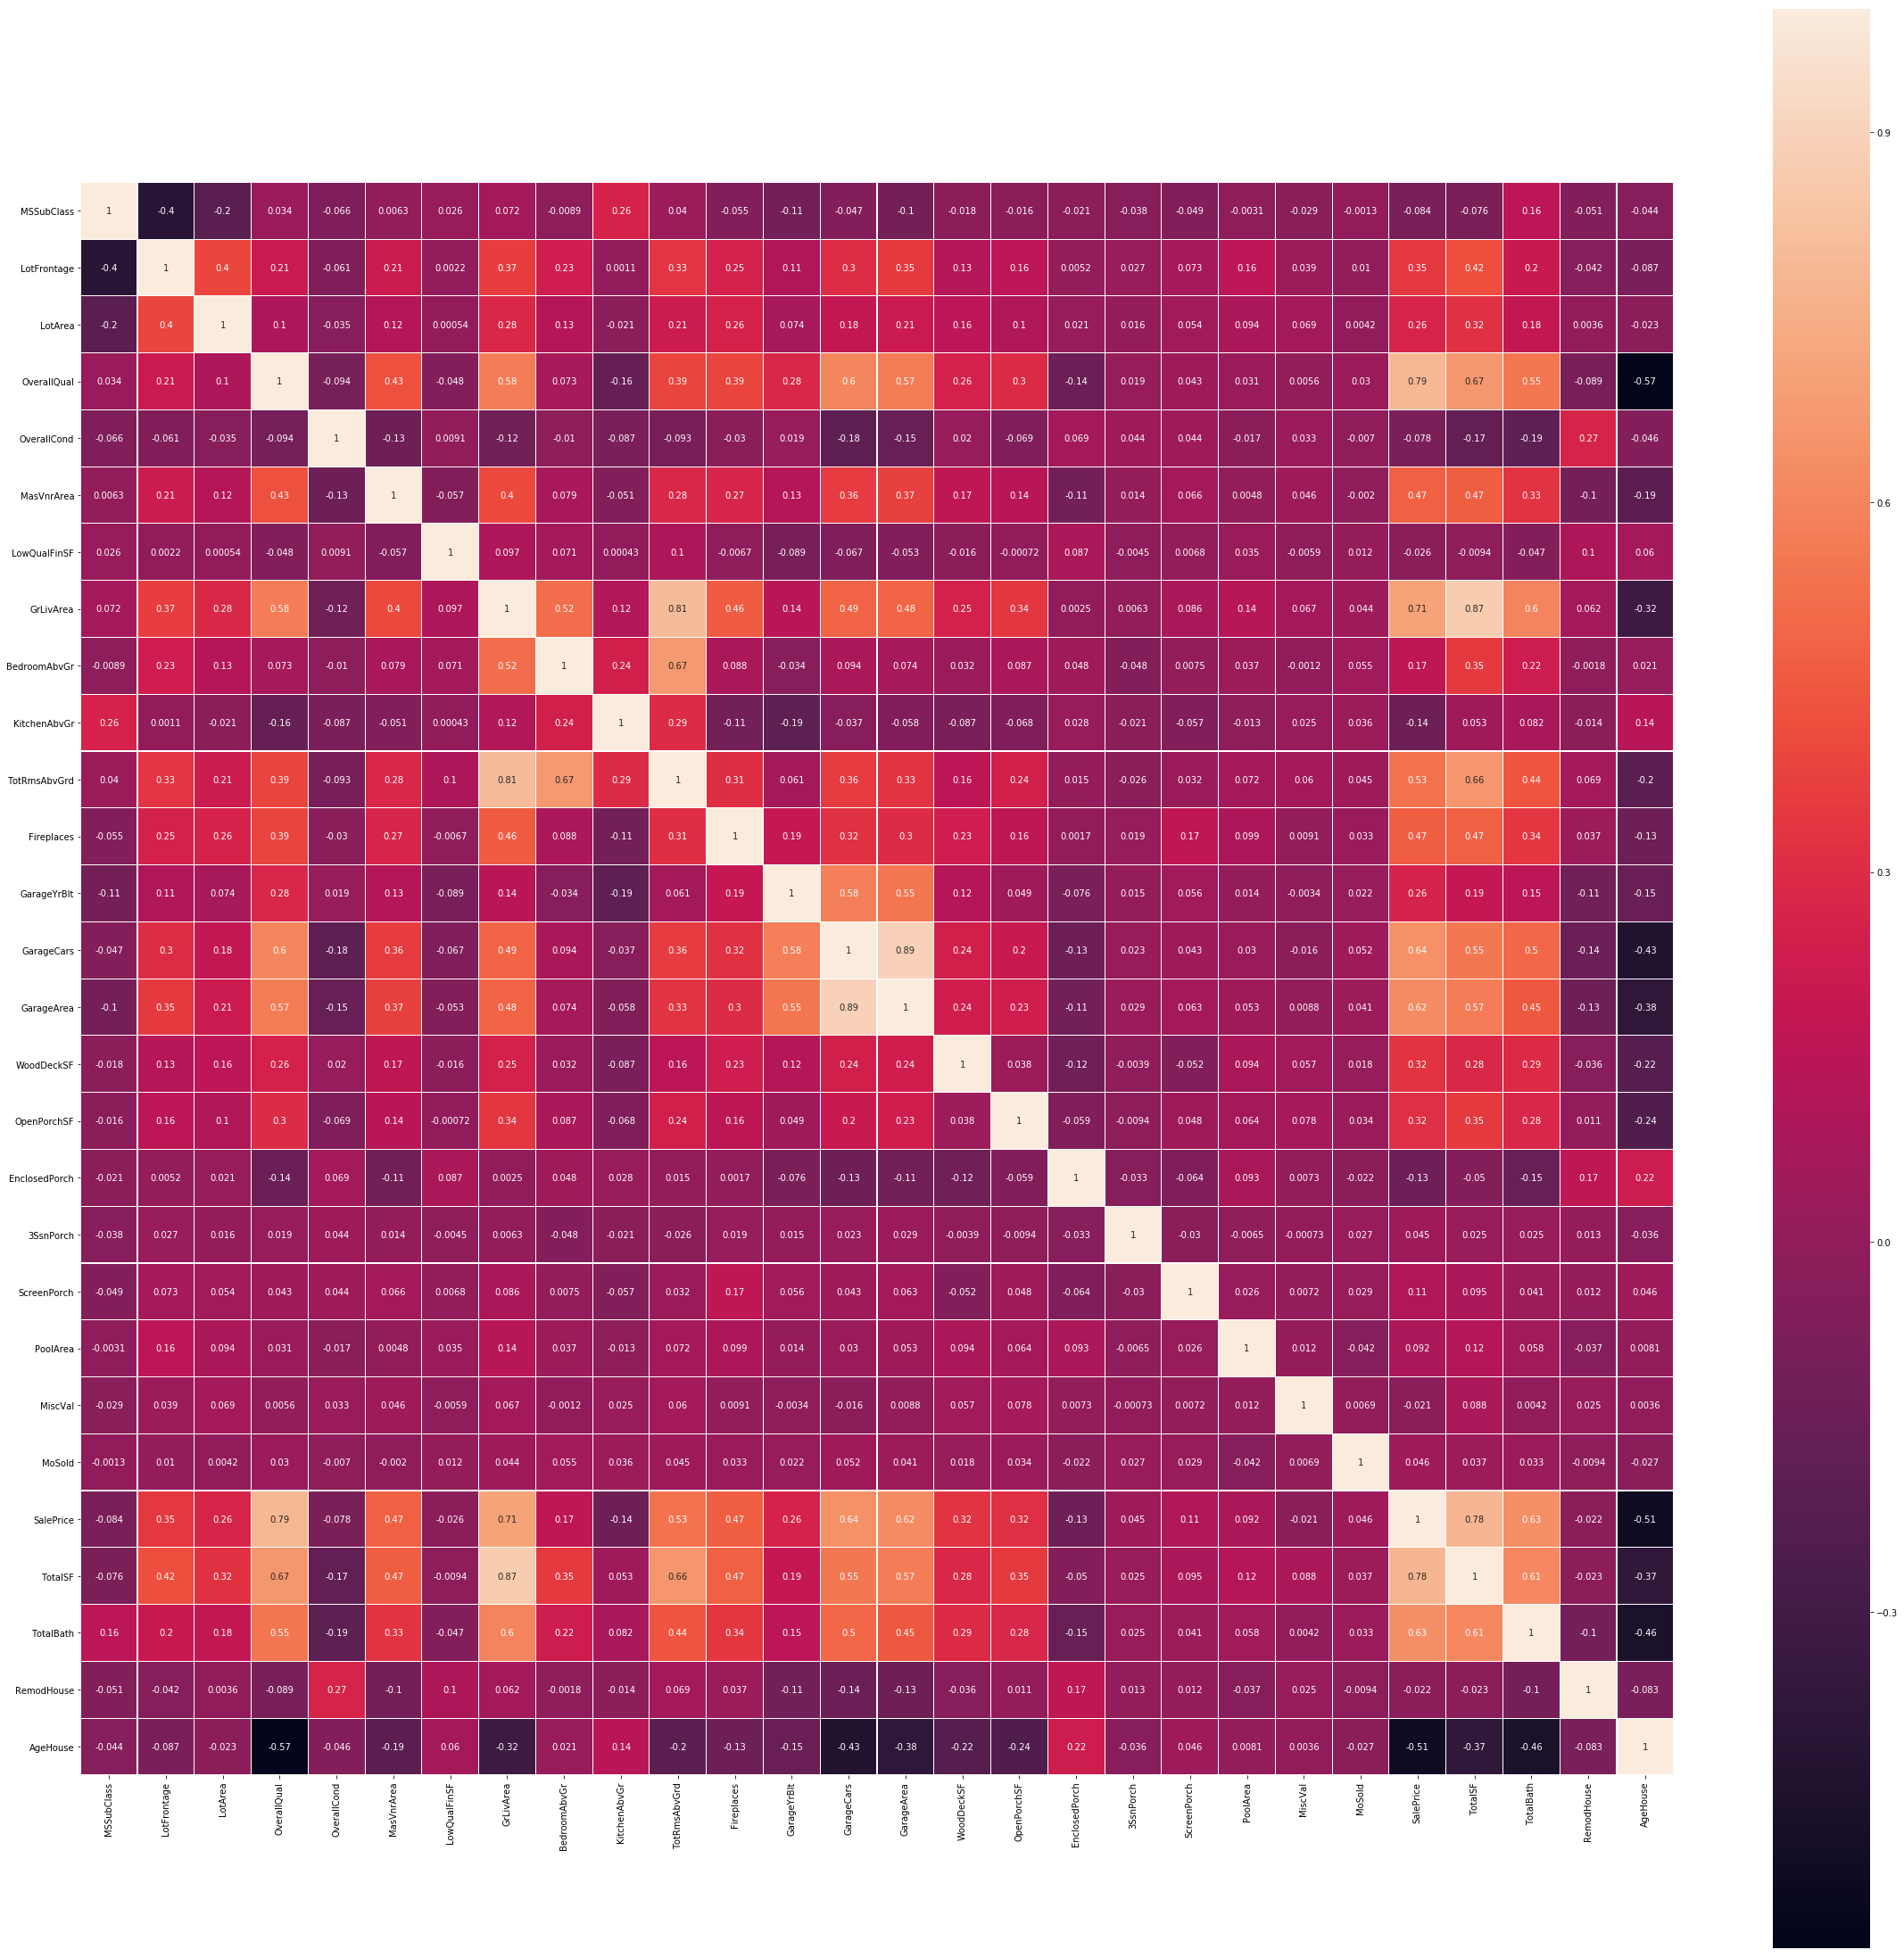

<Figure size 432x288 with 0 Axes>

In [120]:
plt.figure(figsize=(40,40))
sns.heatmap(full_df.select([c for c in full_df.columns]).toPandas().corr(), 
            linewidths = 0.1, vmax=1, square=True, linecolor='white', annot=True)
plt.show()
plt.gcf().clear()

Para cada para de variables altamente correladas, eliminaremos aquella con una correlación más baja con la variable respuesta.

In [121]:
import numpy as np
corr_num = full_df.select([c for c in full_df.columns if c != 'SalePrice']).toPandas().corr()
to_drop = [column for column in corr_num.columns if any(np.abs(corr_num[column][corr_num[column] != 1] > 0.7))]
to_drop

['GrLivArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'TotalSF']

Atendiendo a la matriz de correlación representada anteriormente tenemos los siguientes pares de variables altamente correladas:

* **GrLivArea - TotalSF**
* **GrLivArea - TotRmsAbvGrd**
* **GarageCars - GarageArea**

Analizamos la correlación de dichas variables con la variable respuesta:

In [122]:
full_df.select([c for c in full_df.columns]).toPandas().corr()['SalePrice'][to_drop]

GrLivArea       0.708624
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
TotalSF         0.782260
Name: SalePrice, dtype: float64

Así pues eliminaremos las variables: **GrLivArea** y **GarageArea** pues son las variables que presentan una correlación más baja con la variable respuesta (en comparación con la otra variable con la que se encuentra correlada).

In [123]:
full_df = full_df.drop('GrLivArea', 'GarageArea')

## Preparación de los datos

Dividimos nuestro set de datos en train y test, ya que usaremos el conjunto de entrenamiento para la preparación y entrenamiento de los modelos y el conjunto test para validarlos.

Puesto que nuestro set de datos está limpio de valores missing, sólo tenemos los registros missing de la variable respuesta a predecir, accedemos a los registros donde dicha variable presenta valores missing para formar nuestro conjunto test.

In [124]:
train_df = full_df.filter(F.col('SalePrice').isNotNull())
test_df = full_df.filter(F.col('SalePrice').isNull())

### Conversión de variables categóricas a numéricas

Puesto que los modelos sólo admiten valores numéricos, debemos convertir las variables de tipo 'string' a variables numéricas. Para ello, haremos uso del **OneHotEncoder**.

In [125]:
train_df.dtypes

[('MSSubClass', 'int'),
 ('Neighborhood', 'string'),
 ('MSZoning', 'string'),
 ('LotFrontage', 'double'),
 ('LotArea', 'int'),
 ('Street', 'string'),
 ('LotShape', 'string'),
 ('LandContour', 'string'),
 ('LotConfig', 'string'),
 ('LandSlope', 'string'),
 ('Condition1', 'string'),
 ('Condition2', 'string'),
 ('BldgType', 'string'),
 ('HouseStyle', 'string'),
 ('OverallQual', 'int'),
 ('OverallCond', 'int'),
 ('RoofStyle', 'string'),
 ('RoofMatl', 'string'),
 ('Exterior1st', 'string'),
 ('Exterior2nd', 'string'),
 ('MasVnrType', 'string'),
 ('MasVnrArea', 'int'),
 ('ExterQual', 'string'),
 ('ExterCond', 'string'),
 ('Foundation', 'string'),
 ('BsmtQual', 'string'),
 ('BsmtCond', 'string'),
 ('BsmtExposure', 'string'),
 ('BsmtFinType1', 'string'),
 ('BsmtFinType2', 'string'),
 ('Heating', 'string'),
 ('HeatingQC', 'string'),
 ('CentralAir', 'string'),
 ('Electrical', 'string'),
 ('LowQualFinSF', 'int'),
 ('BedroomAbvGr', 'int'),
 ('KitchenAbvGr', 'int'),
 ('KitchenQual', 'string'),
 ('To

In [126]:
features_cat = [train_df.dtypes[i][0] for i in range(len(train_df.dtypes)) if train_df.dtypes[i][1] == 'string']
print("Tenemos un total de {} variables categóricas.".format(len(features_cat)))

Tenemos un total de 37 variables categóricas.


In [127]:
features_num = [train_df.dtypes[i][0] for i in range(len(train_df.dtypes)) if (train_df.dtypes[i][1] == 'int') |
               (train_df.dtypes[i][1] == 'double')]
print("Tenemos un total de {} variables numéricas.".format(len(features_num)))

Tenemos un total de 26 variables numéricas.


Cambiamos el orden de las variables del conjunto train y test:

In [128]:
features_columns = [column for column in features_num if column != 'SalePrice'] + features_cat + ['SalePrice']

In [129]:
train_df = train_df.select(features_columns)
test_df = test_df.select(features_columns)

### OneHotEncoding and assembling - Estandarización e importancia de variables

> Codificador **OneHotEncoder**: este codificador asigna una columna de índices de etiqueta a una columna de vectores binarios, con un solo valor uno como máximo. Esta codificación permite aplicar algoritmos que esperan características con valores numéricos a características categóricas.

* Definimos en primer lugar el listado de variables numéricas y categóricas:

In [130]:
cat_var = [i[0] for i in train_df.dtypes if (i[1]=='string') & (i[0]!="SalePrice")]
num_var = [i[0] for i in train_df.dtypes if ((i[1]=='int') | (i[1]=='double')) & (i[0]!='SalePrice')]

* Creamos los objetos que van a formar parte de nuestro **pipeline**. Empezamos aquí la conversión de las variables categóricas a numéricas:

In [131]:
string_indexes = [StringIndexer(inputCol = c, outputCol = c + '_index', handleInvalid = 'keep') for c in cat_var]
onehot_indexes = [OneHotEncoder(inputCol = c + '_index', outputCol = c + '_oneHot') for c in cat_var]

* Para aplicar modelos necesitamos estructurar los datos en forma de **features/label**. Para ello, usamos ahora la función **VectorAssembler**, que es un transformer que, a partir de un conjunto de columnas de entrada, genera una columna de salida que contiene un vector con los datos de todas las columnas introducidas. (es importante mantener el orden de las columnas)

In [132]:
assembler = VectorAssembler(inputCols = num_var + [c + '_oneHot' for c in cat_var], outputCol = 'features')

* Efectuamos el proceso de **estandarización de las variables** para unificar la escala de cada atributo. Dicho objeto también formará parte de nuestro **pipelineModel** que posteriormente crearemos.

In [133]:
standarization = StandardScaler(inputCol="features", outputCol="features_norm", withStd=True, withMean=True)

* Recurrimos al algoritmo **RandomForestRegressor** que nos permita obtener una importancia de variables para así llevar a cabo una reducción de nuestro espacio predictor:

In [134]:
rf = RandomForestRegressor(labelCol="SalePrice", featuresCol="features_norm", seed=1234, 
                          numTrees=50, cacheNodeIds=True, subsamplingRate = 0.7)

> Comentamos los parámetros incluidos en nuestro modelo:

> * **numTrees**: número de árboles a contruir.
> * **subsamplingRate**: fracción de la muestra de entrenamiento tomada para la construcción de cada árbol (muestra bootstrap)
> * **cacheNodeIds**: igual a TRUE el algoritmo almacena en caché las ID de nodo para cada instancia (permite acelerar el entrenamiento de árboles).
    

* Así, una vez definidas nuestras nuevas variables y definido el modelo a partir del cual vamos a obtener una importancia de variables, estamos en condiciones de definir nuestro objeto **pipeline**:

In [135]:
pipeline = Pipeline(stages = string_indexes + onehot_indexes + [assembler, standarization, rf])

> Ahora mismo nuestro **pipeline** es un **estimator** (no está aun entrenado)

In [136]:
preprocessing_pl = pipeline.fit(train_df)

> Haremos uso de las funciones **save** y **load** para guardar el objeto pipeline ya entrenado (ya es un transformer) y cargarlo posteriormente para reducir el tiempo de ejecución a la hora de cargar el notebook y mantener el mismo tratamiento de los datos:

In [281]:
preprocessing_pl.save('preprocessing_pl')

In [288]:
loadPreprocessing = PipelineModel.load('preprocessing_pl')

> Ahora nuestro pipelineModel es un **Transformer**. Lo podemos usar para transformar cualquier dataset con la misma estructura.

In [137]:
train_final = preprocessing_pl.transform(train_df) # o bien, loadPreprocessing.transform(train_df)

> Nuestro pipelineModel contiene todo el preprocesado que hemos realizado. Así, para cada nuevo conjunto de datos podemos aplicarle el mismo preprocesado con una única llamada.

In [138]:
test_final = preprocessing_pl.transform(test_df) # o bien, loadPreprocessing.transform(test_df)

* Estamos ya en condiciones de conocer qué variables presentan una importancia más elevada en nuestro modelo predictivo:

> Ahora bien, la importancia de las variables explicativas que se devuelve se presenta en forma de un vector disperso. Esto dificulta la comprensión y su interpretación luego recurriremos a **pandas** para crear una función que nos permita obtener el nombre de cada variable con su importancia para, posteriormente, realizar la selección de variables.

In [139]:
preprocessing_pl.stages[-1].featureImportances

SparseVector(266, {0: 0.0027, 1: 0.0069, 2: 0.0149, 3: 0.225, 4: 0.0027, 5: 0.0087, 6: 0.0001, 7: 0.0017, 8: 0.0003, 9: 0.0103, 10: 0.0139, 11: 0.0366, 12: 0.0932, 13: 0.0032, 14: 0.0044, 15: 0.0001, 17: 0.0012, 18: 0.0033, 20: 0.002, 21: 0.308, 22: 0.0448, 23: 0.001, 24: 0.0102, 25: 0.0001, 26: 0.0001, 27: 0.0002, 28: 0.0003, 29: 0.0002, 31: 0.0005, 36: 0.0005, 37: 0.0002, 38: 0.0041, 40: 0.0001, 41: 0.0, 43: 0.0007, 45: 0.0, 50: 0.001, 51: 0.0013, 54: 0.0001, 57: 0.0002, 59: 0.0002, 60: 0.0005, 61: 0.0006, 62: 0.0011, 63: 0.0001, 65: 0.0003, 66: 0.0007, 67: 0.0002, 68: 0.0, 70: 0.0007, 72: 0.0005, 73: 0.0002, 75: 0.0001, 76: 0.0, 90: 0.0003, 91: 0.0, 92: 0.0002, 93: 0.0, 95: 0.0001, 96: 0.0001, 99: 0.0, 103: 0.0005, 104: 0.0001, 106: 0.0, 109: 0.0008, 111: 0.0013, 116: 0.0008, 118: 0.0037, 120: 0.0012, 122: 0.0001, 123: 0.0012, 125: 0.0002, 127: 0.0, 133: 0.0, 134: 0.0018, 135: 0.0, 139: 0.0004, 140: 0.0006, 142: 0.0015, 148: 0.0, 149: 0.0001, 150: 0.0004, 152: 0.0424, 153: 0.011, 15

> **Definición de la función que nos permite obtener, de forma más clara, la importancia de las variables**

In [140]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

> Analizamos la importancia adquirida por las 20 primeras variables (en orden de importancia)

Usaremos la columna **features** para obtener los índices de las variables más importantes. Posteriormente a la hora de tomar las variables más importantes, haremos uso de la columna **features_norm** donde se encuentran las variables estandarizadas.

In [141]:
ExtractFeatureImp(preprocessing_pl.stages[-1].featureImportances, train_final, "features").head(20)

,idx,name,score
21,21,TotalSF,0.307985
3,3,OverallQual,0.224972
12,12,GarageCars,0.093163
169,169,BsmtQual_oneHot_Ex,0.050127
22,22,TotalBath,0.044775
152,152,ExterQual_oneHot_TA,0.042440
11,11,GarageYrBlt,0.036622
2,2,LotArea,0.014887
10,10,Fireplaces,0.013926
216,216,KitchenQual_oneHot_Ex,0.012069


> Ahora que tenemos las características más importantes en una lista bien formateada, podemos extraer las 20 características principales y crear una nueva columna de vector de entrada con solo estas variables. Pyspark tiene una función **VectorSlicer** que hace exactamente eso. Atendiendo a los resultados obteniendo y, como una forma de reducir la complejidad del problema, nos quedaremos con un número aún más reducido, 7 variables. Observamos la gran importancia de las variables **TotalSF** y **OverQuall** en la elaboración del modelo inicial.

In [142]:
varlist = ExtractFeatureImp(preprocessing_pl.stages[-1].featureImportances, train_final, "features")
varidx = [x for x in varlist['idx'][0:7]] # índices de los atributos más importantes

> Guardamos las variables más importantes, es decir, los predictores de nuestros modelos de aprendizaje supervisado para posteriores cálculos:

In [143]:
selected_features = varlist['name'][0:7].tolist()

In [144]:
slicer = VectorSlicer(inputCol="features_norm", outputCol="features_select", indices=varidx)
train_final_impr = slicer.transform(train_final)

> Nos quedamos con las mismas variables en el conjunto test:

In [145]:
test_final_impr = slicer.transform(test_final)

> Observamos que lo que hace la función **VectorSlicer** es tomar de la variable **features_norm** los índices que se encuentran en la lista **varidx**, que son los índices de las variables con mayor importancia. Así, tenemos en la columna de salida, **features_select**, únicamente las variables de índices seleccionados.

In [146]:
train_final_impr = train_final_impr.drop('rawPrediction', 'probability', 'prediction')

* Finalmente, obtenemos nuestro nuevo conjunto de entrenamiento y conjunto test:

In [147]:
df_train = train_final_impr.select(train_final_impr.features_select.alias('atributos'), train_df.SalePrice.alias('target'))
df_test = test_final_impr.select(test_final_impr.features_select.alias('atributos'), test_df.SalePrice.alias('target'))

In [148]:
df_train.show()
df_test.show()

+--------------------+------+
|           atributos|target|
+--------------------+------+
|[-1.0259630462018...|144000|
|[-0.9334734925462...|156000|
|[-0.7850034195727...|198500|
|[-0.9529449775263...|148000|
|[-1.2547529947183...|129500|
|[-1.0551702736720...|137000|
|[-0.7022496084072...|137500|
|[-0.3018671985033...|137500|
|[-1.0356987886918...|134900|
|[-0.4381675933642...|165500|
|[0.63763195178779...|171000|
|[-0.3688004281225...|148000|
|[-1.2547529947183...|133900|
|[-0.7594470955363...|178400|
|[-0.7728337414601...|147000|
|[-0.7825694839502...|134500|
|[-0.4150452049503...|170000|
|[-0.9772843337515...|123000|
|[-1.2547529947183...|133000|
|[-1.0223121427680...|129000|
+--------------------+------+
only showing top 20 rows

+--------------------+------+
|           atributos|target|
+--------------------+------+
|[-0.4369506255529...|  null|
|[-0.8908796191521...|  null|
|[-0.0183136984802...|  null|
|[-0.9943218831091...|  null|
|[-1.3107335140361...|  null|
|[-0.899398393

# Modelos de aprendizaje supervisado
---

A continuación elaboraremos diferentes modelos de aprendizaje supervisado sobre el conjunto de entrenamiento y, posteriormente, predeciremos el valor de nuestra variable objetivo para los registros del conjunto test.

A lo largo de los siguientes apartados necesitaremos fijar una semilla de manera que los resultados sean reproducibles.

In [149]:
global_seed = 1234;

## Partición del conjunto de entrenamiento en dos conjuntos

Dividimos el conjunto de entrenamiento en dos conjuntos; considerando el $70\%$ de los casos para entrenar el modelo y el $30\%$ restante para validarlo.

In [150]:
train_X, train_Y = df_train.randomSplit([0.7, 0.3], seed = global_seed)
print('Tamaño train_x: {}. Tamaño train_y: {}.'.format(train_X.count(), train_Y.count()))
print(train_X.first())
print(train_Y.first())

Tamaño train_x: 1020. Tamaño train_y: 440.
Row(atributos=DenseVector([-1.2548, -0.7949, -1.0265, -0.3005, -0.9048, 0.7817, 0.232]), target=133900)
Row(atributos=DenseVector([-1.2548, -0.7949, 0.3116, -0.3005, -0.2682, 0.7817, 0.2629]), target=133000)


## Algoritmos

### Regresión lineal

* **Definición del modelo de regresión lineal**

En relación a un modelo de regresión lineal podemos hablar de dos parámetros de regularización: $\alpha$ y $\lambda$. Usaremos la regularización **elastic net** ($\alpha$) que contiene tanto la regresión Lasso ($\alpha = 0$) como la regresión Ridge ($\alpha = 1$) y cuyo parámetro pertenece al intervalo [0,1]. Por otro lado, el parámetro $\lambda$ tendrá la reestricción de ser mayor que 0.

In [151]:
lr = LinearRegression(featuresCol = 'atributos', labelCol='target', maxIter=100, regParam=0.5, elasticNetParam=0.8)

* **Entrenamiento del modelo**

In [152]:
lr_model = lr.fit(train_X)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [24705.267057461788,23545.95912102165,12818.205490300783,12783.467371051895,9470.364098218573,-5782.5588483375695,-3024.7745955260075]
Intercept: 179848.00572207343


In [222]:
lr_model.save('models/model_lr')

* **Predicciones**

In [154]:
lr_predict = lr_model.transform(train_Y)
lr_predict.show(5)

+--------------------+------+------------------+
|           atributos|target|        prediction|
+--------------------+------+------------------+
|[-1.2547529947183...|133000|122430.70778347258|
|[-1.0356987886918...|134900|127875.83516489493|
|[-0.9772843337515...|123000|112273.30516241337|
|[-0.9529449775263...|148000|129674.81136873501|
|[-0.7825694839502...|134500|117117.12224828645|
+--------------------+------+------------------+
only showing top 5 rows



> Observamos así la predicción realizada por el modelo para los 5 primeros registros.

* **Evaluación del rendimiento del modelo en el conjunto de validación**

$$RMSLE = \frac{1}{n} \sum{(log(\bar{y_{i}} +1) - log(y_{i} +1))^{2}}$$

Dicho evaluador es la **raíz del error cuadrático medio de la transformación logarítmica sobre los valores predichos y los observados**

En la definición de la métrica, añadimos 1 a los valores reales y predichos antes de tomar el logaritmo natural para evitar tomar el valor 0, en nuestro ejemplo, al tratarse de precios de viviendas no es frecuente esta situación pero añadiendo dicha modificación salvaríamos cualquier problema futuro. Además, cabe mencionar que dicha función no es apropiada si alguno de los elementos reales o predichos tienen valor negativo por la definición de la función logarítmica.

Una vez comentado el mecanismo de dicha métrica nos disponemos a hablar de su **funcionalidad**. La métrica RMSLE mide la **proporción entre la predicción y lo observado**. Dicha métrica suele utilizarse cuando la variable respuesta tiene un crecimiento exponencial, como el conteo de la población o nuestro ejemplo en particular, así, nos preocupamos por los errores porcentuales en lugar del valor absoluto de los mismos. De esta manera, usaremos dicha métrica cuando nuestra variable objetivo tenga un rango muy amplio y no queramos penalizar a las grandes diferencias cuando el valor predicho y el real son números excesivamente grandes.

Introducimos un ejemplo donde podamos observar la comparación de esta métrica con el **RMSE**:
* Supongamos un caso en el que nuestro modelo obteiene una predicción de 20 cuando el valor observado es 40 y otro caso en el que la predicción es 200, siendo el valor real, 400.
* Pues bien, usando la métrica RMSE, el sgundo caso adquiere un error 10 veces más que el primero, mientras que utilizando la nueva métrica definida, los dos casos obtienen el mismo error.

In [155]:
class Evaluator_RMSLE(Evaluator):
    
    def __init__(self, targetCol = "target", predictionCol = "prediction"):
        super(Evaluator_RMSLE, self).__init__()
        self.targetCol = targetCol
        self.predictionCol = predictionCol
        
    def _evaluate(self, dataset):
        error_rmsle = self.rmsle(dataset, self.targetCol, self.predictionCol)
        print("Error RMSLE: {}".format(error_rmsle))
        return error_rmsle
    
    def isLargerBetter(self):
        return False
    
    @staticmethod
    def rmsle(dataset, targetCol, predictionCol):
        return sqrt(dataset.select(avg((log(dataset[predictionCol] + 1) - log(dataset[targetCol] + 1))**2)).first()[0])

> Una vez definido el objeto que utilizaremos como nuestro evaluador del modelo en el conjunto de validación, obtenemos el error cometido por el modelo de regresión previamente entrenado sobre dicho conjunto.

In [156]:
evaluator = Evaluator_RMSLE()

In [157]:
rmsle_lr = evaluator.evaluate(lr_predict)

Error RMSLE: 0.17784238890850584


**Vamos guardando los resultados obtenidos en un diccionario**

In [158]:
result_rmse = {'rl': rmsle_lr}
result_rmse

{'rl': 0.17784238890850584}

#### Optimización de los parámetros

* **Definición de la rejilla de búsqueda de los parámetros:** fijaremos el valor de $\lambda$ en $0.5$ y buscaremos el mejor valor de $\alpha$

In [159]:
lr_cv = LinearRegression(featuresCol = 'atributos', labelCol='target', maxIter = 100, regParam = 0.5)
paramGrid = ParamGridBuilder() \
    .addGrid(lr_cv.elasticNetParam, [0, 0.2, 0.5, 0.8, 1]) \
    .build()

* **Aplicamos validación cruzada con 5 pliegues para la elección del mejor valor del hiperparámetro**

In [177]:
crossval_lr = CrossValidator(estimator = lr_cv,
                             estimatorParamMaps = paramGrid,
                             evaluator = Evaluator_RMSLE(),
                             numFolds = 5, 
                             seed = global_seed) 

In [178]:
lr_cv_model = crossval_lr.fit(train_X)

Error RMSLE: 0.16455684630409934
Error RMSLE: 0.1645565384499798
Error RMSLE: 0.16455606717237833
Error RMSLE: 0.1645555816629585
Error RMSLE: 0.16455526762417244
Error RMSLE: 0.167064142893988
Error RMSLE: 0.16706387644440107
Error RMSLE: 0.16706348711078786
Error RMSLE: 0.16706310417021294
Error RMSLE: 0.16706284467356528
Error RMSLE: 0.18123109440537874
Error RMSLE: 0.18123099086875286
Error RMSLE: 0.1812308358256824
Error RMSLE: 0.18123069134069295
Error RMSLE: 0.18123058800384817
Error RMSLE: 0.1912544110631297
Error RMSLE: 0.19125415308318705
Error RMSLE: 0.19125376607018882
Error RMSLE: 0.19125337889045174
Error RMSLE: 0.19125312401301603
Error RMSLE: 0.23027360133388014
Error RMSLE: 0.23027390810099538
Error RMSLE: 0.2302743821862298
Error RMSLE: 0.2302748627945336
Error RMSLE: 0.23027517895552438


* Obtenemos el score obtenido para cada modelo construido (promediante el error obtenido en los diferentes pliegues):

In [181]:
lr_cv_model.avgMetrics

[0.18687601920009517,
 0.18687589338946323,
 0.18687570767305342,
 0.18687552377176994,
 0.18687540065402525]

> Mostramos a continuación para qué combinación de parámetros se alcanzan los anteriores scores:

In [182]:
par_lr = lr_cv_model.getEstimatorParamMaps()

In [183]:
lpar_lr = [{par.name: value for par, value in par_comb.items()} for par_comb in par_lr]
lpar_lr

[{'elasticNetParam': 0.0},
 {'elasticNetParam': 0.2},
 {'elasticNetParam': 0.5},
 {'elasticNetParam': 0.8},
 {'elasticNetParam': 1.0}]

In [184]:
pars_lr_cv = pd.DataFrame(lpar_lr)
pars_lr_cv['score'] = lr_cv_model.avgMetrics
pars_lr_cv.sort_values(by='score', ascending=False)

,elasticNetParam,score
0,0.0,0.186876
1,0.2,0.186876
2,0.5,0.186876
3,0.8,0.186876
4,1.0,0.186875


> **Conclusión:** obtenemos así el error RMSLE alcanzado por cada modelo construido sobre el conjunto de entrenamiento para los distintos valores del parámetro **elasticNetParam** definido anteriormente. Observamos que para el valor igual a 1 se alcanza el menor score, siendo dicho modelo el que usaremos para analizar su rendimiento sobre el conjunto de validación.

* Podemos obtener un transformer con el mejor modelo ya entrenado. Así, guardamos el mejor modelo resultante del proceso de optimización ya entrenado para futuras predicciones:

In [185]:
best_model_lr_cv = lr_cv_model.bestModel

In [219]:
best_model_lr_cv.save('models/best_model_lr_cv')

* **Cálculo de las predicciones y evaluación del rendimiento del mejor modelo en el conjunto de validación**

In [188]:
lr_cv_predict = best_model_lr_cv.transform(train_Y)
rmse_lr_cv = evaluator.evaluate(lr_cv_predict)

Error RMSLE: 0.1778420454879219


> **Comentraio:** Vemos que hemos conseguido disminuir el error cometido.

In [220]:
loadModelLR = LinearRegressionModel.load('models/best_model_lr_cv')

In [221]:
prueba_lr_cv_predict = loadModelLR.transform(train_Y)
prueba_lr_cv_predict = prueba_lr_cv_predict.withColumnRenamed("prediction", "prediction_after_save")
lr_cv_predict.join(prueba_lr_cv_predict, on=['atributos']).select(['prediction', 'prediction_after_save']).show(5)

+------------------+---------------------+
|        prediction|prediction_after_save|
+------------------+---------------------+
|108108.49299070786|   108108.49299070786|
|107812.07715969258|   107812.07715969258|
|123871.79676067896|   123871.79676067896|
|152478.12660897142|   152478.12660897142|
|178287.52069196955|   178287.52069196955|
+------------------+---------------------+
only showing top 5 rows



**Conclusión:** el proceso de carga y lectura del modelo ha sido correcto.

Guardamos el error cometido en la predicción sobre el conjunto test en el diccionario creado anteriormente como resumen:

In [202]:
result_rmse['rl_cv'] = rmse_lr_cv
result_rmse

{'rl': 0.17784238890850584, 'rl_cv': 0.1778420454879219}

### Random Forest

* **Definición y entrenamiento del modelo**

> Usaremos en primer lugar los argumentos que tiene dicho modelo por defecto y posteriormente veremos como ajustar algunos de sus hiperparámetros.

In [213]:
rf = RandomForestRegressor(featuresCol ='atributos', labelCol = 'target', seed = global_seed)
rf_model = rf.fit(train_X)

In [215]:
rf_model.save('models/model_rf')

* **Importancia de las variables**

In [216]:
rf_model.featureImportances

SparseVector(7, {0: 0.3125, 1: 0.3297, 2: 0.1446, 3: 0.0438, 4: 0.0625, 5: 0.0607, 6: 0.0462})

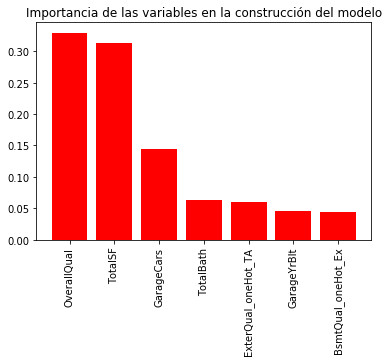

In [217]:
rf_importance = pd.DataFrame({'features': selected_features, 'importance_rf': rf_model.featureImportances.toArray()})
rf_importance = rf_importance.sort_values(by="importance_rf", ascending=False)

plt.bar(range(len(rf_importance.features)), rf_importance.importance_rf, color="red")
plt.xticks(range(len(rf_importance.features)), rf_importance.features, rotation = 90)
plt.title('Importancia de las variables en la construcción del modelo')
plt.show()

* **Predicciones**

In [218]:
rf_predict = rf_model.transform(train_Y)
rf_predict.show(5)

+--------------------+------+------------------+
|           atributos|target|        prediction|
+--------------------+------+------------------+
|[-1.2547529947183...|133000|127562.84820130756|
|[-1.0356987886918...|134900| 134424.4918110425|
|[-0.9772843337515...|123000|128751.45843411353|
|[-0.9529449775263...|148000|133690.67904541432|
|[-0.7825694839502...|134500|128916.13970232545|
+--------------------+------+------------------+
only showing top 5 rows



* **Evaluación del rendimiento del modelo en el conjunto de validación**

In [223]:
rmse_rf = evaluator.evaluate(rf_predict)

Error RMSLE: 0.16423058984152378


In [224]:
result_rmse['rf'] = rmse_rf
result_rmse

{'rl': 0.17784238890850584,
 'rl_cv': 0.1778420454879219,
 'rf': 0.16423058984152378}

#### Optimización de los paramétros

* **Definición de la rejilla de búsqueda de hiperparámetros**

In [225]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [4, 5, 6]) \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .build()

* **Aplicamos validación cruzada con 5 pliegues para la elección del mejor valor del hiperparámetro**

In [226]:
crossval_rf = CrossValidator(estimator = rf,
                             estimatorParamMaps = paramGrid,
                             evaluator = Evaluator_RMSLE(),
                             numFolds = 5, 
                             seed = global_seed) 

In [227]:
rf_cv_model = crossval_rf.fit(train_X)

Error RMSLE: 0.18139759022286722
Error RMSLE: 0.18098491569005046
Error RMSLE: 0.1810005278314452
Error RMSLE: 0.17065813650647346
Error RMSLE: 0.17262255696798312
Error RMSLE: 0.1717831956308604
Error RMSLE: 0.16754503495189807
Error RMSLE: 0.16742822403197458
Error RMSLE: 0.16706470175626742
Error RMSLE: 0.15430891040601905
Error RMSLE: 0.15271566086867167
Error RMSLE: 0.15470403158170087
Error RMSLE: 0.14773931600266235
Error RMSLE: 0.14609187018683065
Error RMSLE: 0.14759891827338412
Error RMSLE: 0.14507072097554918
Error RMSLE: 0.14220298689340513
Error RMSLE: 0.14389118080291152
Error RMSLE: 0.1726474654628221
Error RMSLE: 0.17289710321167895
Error RMSLE: 0.1727921442251191
Error RMSLE: 0.16264249981593953
Error RMSLE: 0.16245060692973712
Error RMSLE: 0.16301171383163698
Error RMSLE: 0.15712402146833637
Error RMSLE: 0.15721466158787467
Error RMSLE: 0.15743577636168152
Error RMSLE: 0.16968049181435427
Error RMSLE: 0.16815221897370597
Error RMSLE: 0.1688982013729492
Error RMSLE: 0.

> Como hemos hecho en anteriores modelos, guardamos el objeto creado ya entrenado para futuros cálculos y para, mediante la función **load()** poder calcular las predicciones sobre el conjunto de validación sin necesidad de ejecutar el procedimiento de ajuste de parámetros nuevamente lo cual conlleva un elevado tiempo de ejecución cuando sea necesario-

In [228]:
best_model_rf_cv = rf_cv_model.bestModel
best_model_rf_cv.save('models/best_model_rf_cv')

* Analizamos los resultados obtenidos para cada modelo construido promediando el error obtenido en los distintos pliegues:

In [231]:
rf_cv_model.avgMetrics

[0.18141454562071324,
 0.18018788408956013,
 0.18088081791818247,
 0.17196658502953527,
 0.1713438327746129,
 0.1724351772920934,
 0.16786461782387685,
 0.16692203819368118,
 0.16807800183785573]

> Mostramos a continuación el error cometido por el modelo para las diferentes combinaciones de los parámetros posibles dentro de la rejilla *paramGrid* definida anteriormente.

In [232]:
par_rf = rf_cv_model.getEstimatorParamMaps()

In [233]:
lpar_rf = [{par.name: value for par, value in par_comb.items()} for par_comb in par_rf]
lpar_rf

[{'maxDepth': 4, 'numTrees': 50},
 {'maxDepth': 4, 'numTrees': 100},
 {'maxDepth': 4, 'numTrees': 150},
 {'maxDepth': 5, 'numTrees': 50},
 {'maxDepth': 5, 'numTrees': 100},
 {'maxDepth': 5, 'numTrees': 150},
 {'maxDepth': 6, 'numTrees': 50},
 {'maxDepth': 6, 'numTrees': 100},
 {'maxDepth': 6, 'numTrees': 150}]

In [234]:
pars_rf_cv = pd.DataFrame(lpar_rf)
pars_rf_cv['score'] = rf_cv_model.avgMetrics
pars_rf_cv.sort_values(by='score', ascending=False)

,maxDepth,numTrees,score
0,4,50,0.181415
2,4,150,0.180881
1,4,100,0.180188
5,5,150,0.172435
3,5,50,0.171967
4,5,100,0.171344
8,6,150,0.168078
6,6,50,0.167865
7,6,100,0.166922


> **Conclusión:** Obtenemos así el error RMSLE alcanzado por cada algoritmo generado a partir de las distintas combinaciones posibles entre los parámetros. Así, vemos que el modelo que alcanza un menor error sobre el conjunto de aprendizaje y, que posteriormente evaluaremos su rendimiento sobre el conjunto test, es aquel algoritmo random forest cuyos parámetros **maxDepth** y **numTress** son 6 y 100, respectivamente.

* **Importancia de variables del mejor modelo obtenido tras el ajuste de los hiperparámetros**

In [238]:
best_model_rf_cv.featureImportances

SparseVector(7, {0: 0.3226, 1: 0.3092, 2: 0.1302, 3: 0.0368, 4: 0.0783, 5: 0.0684, 6: 0.0545})

In [239]:
rf_cv_importance = pd.DataFrame({'features': selected_features, 
                                 'importance_rf_cv': best_model_rf_cv.featureImportances.toArray()})

pd.merge(rf_importance, rf_cv_importance, on='features').sort_values(by='importance_rf_cv', ascending=False)

,features,importance_rf,importance_rf_cv
1,TotalSF,0.312534,0.322561
0,OverallQual,0.329740,0.309219
2,GarageCars,0.144580,0.130210
3,TotalBath,0.062467,0.078297
4,ExterQual_oneHot_TA,0.060705,0.068397
5,GarageYrBlt,0.046186,0.054520
6,BsmtQual_oneHot_Ex,0.043788,0.036795


* **Cálculo de las predicciones y evaluación del rendimiento del mejor modelo en el conjunto de validación**

In [240]:
rf_cv_predict = best_model_rf_cv.transform(train_Y)
rmse_rf_cv = evaluator.evaluate(rf_cv_predict)

Error RMSLE: 0.15839426415339303


> **Conclusión:** obtenemos una mejora con respecto al modelo random forest sin realizar optimización de los parámetros.

In [241]:
result_rmse['rf_cv'] = rmse_rf_cv
result_rmse

{'rl': 0.17784238890850584,
 'rl_cv': 0.1778420454879219,
 'rf': 0.16423058984152378,
 'rf_cv': 0.15839426415339303}

### Gradient Boosting Trees

Boosting es un enfoque de Machine Learning basado en la idea de crear una regla de predicción altamente precisa combinando muchas reglas relativamente débiles e imprecisas. 

Los árboles de decisión son agregados de forma sucesiva, y los árboles existentes en el modelo no cambian. Para determinar los parámetros que tendrán cada uno de los árboles de decisión que son agregados al modelo se utiliza un procedimiento de gradiente descendiente que minimizará la función de perdida. De esta forma se van agregando árboles con distintos parámetros de forma tal que la combinación de ellos minimiza la pérdida del modelo y mejora la predicción.

* **Definición del modelo**

In [242]:
gbt = GBTRegressor(featuresCol = 'atributos', labelCol = 'target', maxIter = 50, seed=global_seed)

* **Definición de la rejilla de valores para la búsqueda de la mejor combinación de los parámetros**

In [243]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [4, 5]) \
    .addGrid(gbt.stepSize, [0.01, 0.05, 0.1]) \
    .build()

> * **stepSize:** tasa de aprendizaje que permite controlar el error cometido en las iteraciones anteriores. 
> * **maxDepth:** máxima profundidad en cada uno de los algoritmos débiles (árboles de decisión) construidos.
> * **maxIter:** número máximo de árboles de decisión (algoritmos débiles) construidos.

* **Validación cruzada con 3 pliegues para encontrar el mejor modelo posible**

In [244]:
crossval_gbt = CrossValidator(estimator = gbt,
                              estimatorParamMaps = paramGrid,
                              evaluator = Evaluator_RMSLE(),
                              numFolds = 3, 
                              seed = global_seed) 

gbt_cv_model = crossval_gbt.fit(train_X)

Error RMSLE: 0.18445401385618412
Error RMSLE: 0.17259923194439017
Error RMSLE: 0.1700116020658515
Error RMSLE: 0.17781391740455849
Error RMSLE: 0.17609236097096148
Error RMSLE: 0.18529221123846795
Error RMSLE: 0.19848513109259547
Error RMSLE: 0.18607889694658683
Error RMSLE: 0.1870952851930872
Error RMSLE: 0.2038475728474268
Error RMSLE: 0.19715367945315232
Error RMSLE: 0.1998699670892436
Error RMSLE: 0.21687616787655967
Error RMSLE: 0.1999373715517741
Error RMSLE: 0.19687489505189773
Error RMSLE: 0.21326759830813877
Error RMSLE: 0.2082757426223654
Error RMSLE: 0.2059834219222755


> Guradamos el modelo para usarlo en futuros cálculos así como para no cargar el modelo cada vez que abramos el notebook debido a su elevado tiempo de ejecución:

In [245]:
best_model_gbt_cv = gbt_cv_model.bestModel
best_model_gbt_cv.save('models/best_model_gbt_cv')

* Analizamos el rendimiento obtenido de cada modelo promediando el error alcanzando en cada uno de los pliegues:

In [246]:
gbt_cv_model.avgMetrics

[0.19993843760844643,
 0.18620516681425037,
 0.18466059410361213,
 0.19830969618670802,
 0.1938405943488264,
 0.19704853341666234]

> Obtenemos ahora qué parámetros de la rejilla de búsqueda definen a cada modelo, así como su score alcanzado (error obtenido sobre el conjunto de entrenamiento del modelo generado con dicha combinación de parámetros):

In [247]:
par_gbt = gbt_cv_model.getEstimatorParamMaps()

In [248]:
lpar_gbt = [{par.name: value for par, value in par_comb.items()} for par_comb in par_gbt]
lpar_gbt

[{'maxDepth': 4, 'stepSize': 0.01},
 {'maxDepth': 4, 'stepSize': 0.05},
 {'maxDepth': 4, 'stepSize': 0.1},
 {'maxDepth': 5, 'stepSize': 0.01},
 {'maxDepth': 5, 'stepSize': 0.05},
 {'maxDepth': 5, 'stepSize': 0.1}]

In [249]:
pars_gbt_cv = pd.DataFrame(lpar_gbt)
pars_gbt_cv['score'] = gbt_cv_model.avgMetrics
pars_gbt_cv.sort_values(by='score', ascending=False)

,maxDepth,stepSize,score
0,4,0.01,0.199938
3,5,0.01,0.198310
5,5,0.10,0.197049
4,5,0.05,0.193841
1,4,0.05,0.186205
2,4,0.10,0.184661


> **Conclusión:** obtenemos así que el modelo que alcanza un menor error RMSLE por validación cruzada es aquel cuyos parámetros **maxDepth** y **stepSize** son $4$ y $0.1$ respectivamente.

* **Importancia de variables del mejor modelo tras la optimización**

In [250]:
best_model_gbt_cv.featureImportances

SparseVector(7, {0: 0.2395, 1: 0.1924, 2: 0.0729, 3: 0.0264, 4: 0.1807, 5: 0.0221, 6: 0.266})

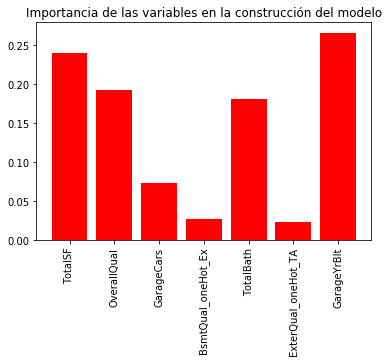

In [251]:
gbt_importance = pd.DataFrame({'features': selected_features, 
                               'importance_gbt': best_model_gbt_cv.featureImportances.toArray()})
gbt_importance.sort_values(by='importance_gbt', ascending=False)

plt.bar(range(len(gbt_importance.features)), gbt_importance.importance_gbt, color="red")
plt.xticks(range(len(gbt_importance.features)), gbt_importance.features, rotation = 90)
plt.title('Importancia de las variables en la construcción del modelo')
plt.show()

> * Comparamos la importancia de variables obtenida usando los diferentes modelos construidos

In [252]:
table_importance_rf = pd.merge(rf_importance, rf_cv_importance, on='features') \
                        .sort_values(by='importance_rf_cv', ascending=False)

pd.merge(table_importance_rf, gbt_importance, on='features')

,features,importance_rf,importance_rf_cv,importance_gbt
0,TotalSF,0.312534,0.322561,0.239459
1,OverallQual,0.329740,0.309219,0.192353
2,GarageCars,0.144580,0.130210,0.072859
3,TotalBath,0.062467,0.078297,0.180723
4,ExterQual_oneHot_TA,0.060705,0.068397,0.022114
5,GarageYrBlt,0.046186,0.054520,0.266047
6,BsmtQual_oneHot_Ex,0.043788,0.036795,0.026444


* **Predicciones y evaluación del rendimiento del mejor modelo encontrado en el conjunto de validación**

In [253]:
gbt_cv_predict = best_model_gbt_cv.transform(train_Y)
rmse_gbt_cv = evaluator.evaluate(gbt_cv_predict)

Error RMSLE: 0.16483759994467906


In [263]:
loadModelGBT = GBTRegressionModel.load('models/best_model_gbt_cv')

In [264]:
prueba_gbt_cv_predict = loadModelGBT.transform(train_Y)
prueba_gbt_cv_predict = prueba_gbt_cv_predict.withColumnRenamed("prediction", "prediction_after_save")
gbt_cv_predict.join(prueba_gbt_cv_predict, on=['atributos']).select(['prediction', 'prediction_after_save']).show(5)

+------------------+---------------------+
|        prediction|prediction_after_save|
+------------------+---------------------+
|124954.83465152358|   124954.83465152358|
| 120869.3471099028|    120869.3471099028|
| 130190.5046930335|    130190.5046930335|
|147680.26249451592|   147680.26249451592|
|152175.25713880718|   152175.25713880718|
+------------------+---------------------+
only showing top 5 rows



> Observamos que el proceso de extracción y lectura del modelo generado y, posteriormente, realizar las predicciones ha sido correcto.

* Finalmente, obtenemos el **score** obtenido por cada modelo y lo representamos por medio de un diccionario y un dataframe

In [254]:
result_rmse['gbt_cv'] = rmse_gbt_cv
result_rmse

{'rl': 0.17784238890850584,
 'rl_cv': 0.1778420454879219,
 'rf': 0.16423058984152378,
 'rf_cv': 0.15839426415339303,
 'gbt_cv': 0.16483759994467906}

In [280]:
result_df = pd.DataFrame.from_dict(result_rmse, orient='index', columns=['Error RMSLE']) \
                .sort_values(by='Error RMSLE', ascending=True)

result_df.index = ['Random Forest Cross-Validation', 
                   'Random Forest', 
                   'Gradient Boosting Trees Cross-Validation', 
                   'Logistic Regression Cross-Validation',
                   'Logistic Regression'] 

result_df

,Error RMSLE
Random Forest Cross-Validation,0.158394
Random Forest,0.164231
Gradient Boosting Trees Cross-Validation,0.164838
Logistic Regression Cross-Validation,0.177842
Logistic Regression,0.177842


> Una vez almacenado todos los resultados, nos disponemos a realizar las predicciones. Para ello, nos quedaremos con el modelo que alcanza un error más bajo: **Random Forest con ajuste de hiperparámetros**.

In [255]:
best_model = best_model_rf_cv

## Predicciones sobre el conjunto test

In [256]:
predicciones = best_model.transform(df_test)
predicciones.show(5)

+--------------------+------+------------------+
|           atributos|target|        prediction|
+--------------------+------+------------------+
|[-0.4369506255529...|  null|142366.43663749236|
|[-0.8908796191521...|  null| 136854.9827023929|
|[-0.0183136984802...|  null|172178.42500981764|
|[-0.9943218831091...|  null|  102163.377206265|
|[-1.3107335140361...|  null| 128473.3712794943|
+--------------------+------+------------------+
only showing top 5 rows



* Guardamos el resultado en un fichero .csv:

In [257]:
predicciones.select(['prediction']).toPandas().to_csv('prediction_test.csv')

In [ ]:
#spark.stop()